### Multiple Stock Prediction

#### Seed programs from the course materials for this notebook:​

#### 1) pharma_stocks_RETPRED_PREDPROBA.ipynb ​

#### 2) 03_preparing_the_model_data_mod_DoNotRunReadOnly.ipynb​

#### 3) HomeworkKerasCustom_UPLOAD homework​

### Importing all the Relevant Libraries

In [ ]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import seaborn as sns
from datetime import datetime
!pip install alphalens
import alphalens
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
from scipy.special import ndtr
from scipy.stats import spearmanr
import tqdm
from functools import partial
from scipy.stats import norm
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from matplotlib import pyplot
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error


# Regression Models
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR, NuSVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor

!pip install shap 
import shap

### Importing the Data

#### Prior to importing the the dataset below ("Complete_DataFrame.csv"), I perfomed the following on the original dataset: 

1.   Clean the Data: Imputed all the NaN values with appropriate values.
2.   Feature Selection: I check for feature collinearity using SNS Heatmap, removed high correlated features in order to reduce model complexity, and picked the final features to train my model using Recursive Feature Elimination (RFE). 
3. Feature Tuning: Lastly, I wanted to check if feature smoothing is required for my data. I plotted Seasonal Decomposition, density and histogram plots for all the features. I concluded no feature smoothing is required based on my findings. 

All the above work has been completed in the "Data_Preparation" Notebook. For more details on the data preparation steps, please refer to the "Data_Preparation" Notebook. 

In [ ]:
# Importing the dataset 
Complete_DataFrame=pd.read_csv('Complete_DataFrame.csv') # The dataset is from the "Data_Preparation" Notebook
Complete_DataFrame.drop('Unnamed: 0',axis=1,inplace=True)
Complete_DataFrame['Year'] = pd.DatetimeIndex(Complete_DataFrame['date']).year
Complete_DataFrame.set_index(["TICKER","date"], inplace=True)
Complete_DataFrame

OPENPRC        PRC         vol    sprtrn       dix  \
TICKER date                                                               
AAPL   2011-01-03  325.64001  329.57001         0.0  0.011315  0.422730   
       2011-01-04  332.44000  331.29001  16438280.0 -0.001313  0.422730   
       2011-01-05  329.54999  334.00000  11444072.0  0.005007  0.422730   
       2011-01-06  334.71899  333.73001   9486655.0 -0.002123  0.422730   
       2011-01-07  333.98999  336.12000  11138250.0 -0.001845  0.422730   
...                      ...        ...         ...       ...       ...   
MSFT   2022-03-25  305.23001  303.67999  24464722.0  0.005066  0.497449   
       2022-03-28  304.32999  310.70001  22544459.0  0.007145  0.491188   
       2022-03-29  313.91000  315.41000  29560701.0  0.012257  0.473442   
       2022-03-30  313.76001  313.85999  30349457.0 -0.006294  0.500846   
       2022-03-31  313.89999  308.31000  28134409.0 -0.015653  0.472040   

                            gex   vixo  lag_ret0  lag_ret1  lag_ret2  ...  \
TICKER date                                                           ...   
AAPL   2011-01-03  2.763341e+09  17.94  0.000000  0.000000  0.000000  ...   
       2011-01-04  2.763341e+09  17.34  0.020882  0.000000  0.000000  ...   
       2011-01-05  2.763341e+09  17.81 -0.008693  0.020882  0.000000  ...   
       2011-01-06  2.763341e+09  16.80  0.015685 -0.008693  0.020882  ...   
       2011-01-07  2.763341e+09  17.31 -0.002178  0.015685 -0.008693  ...   
...                         ...    ...       ...       ...       ...  ...   
MSFT   2022-03-25  4.652304e+09  21.87  0.020358 -0.004559  0.002368  ...   
       2022-03-28  8.319654e+09  22.14 -0.002949  0.020358 -0.004559  ...   
       2022-03-29  9.140785e+09  19.70  0.031479 -0.002949  0.020358  ...   
       2022-03-30  8.005331e+09  19.38 -0.000478  0.031479 -0.002949  ...   
       2022-03-31  3.976160e+09  19.68  0.000446 -0.000478  0.031479  ...   

                     bb_low      macd  EMA For 50 Days        ADX  \
TICKER date                                                         
AAPL   2011-01-03  0.070503  0.000000         0.000000  27.808766   
       2011-01-04  0.070503  0.000000         0.000000  27.808766   
       2011-01-05  0.070503  0.000000         0.000000  27.808766   
       2011-01-06  0.070503  0.000000         0.000000  27.808766   
       2011-01-07  0.070503  0.000000         0.000000  27.808766   
...                     ...       ...              ...        ...   
MSFT   2022-03-25  0.092213  0.104605       299.455198  16.187812   
       2022-03-28  0.091832  0.388912       299.896171  16.502752   
       2022-03-29  0.112858  0.895229       300.504556  17.965364   
       2022-03-30  0.127970  1.473633       301.028299  19.947739   
       2022-03-31  0.126505  1.841548       301.313856  21.220961   

                   PutCallParity  PutCallRatio        BID        ASK  \
TICKER date                                                            
AAPL   2011-01-03     177.707767      0.595386  329.70999  329.72000   
       2011-01-04     178.826154      0.746331  331.29001  331.29999   
       2011-01-05     180.856263      0.566319  333.97000  334.00000   
       2011-01-06     164.545590      0.394729  333.64999  333.79001   
       2011-01-07     166.496499      0.711551  336.12000  336.26001   
...                          ...           ...        ...        ...   
MSFT   2022-03-25     -36.362854      0.542836  303.67999  303.69000   
       2022-03-28     -36.362854      0.542836  310.75000  310.76001   
       2022-03-29     -36.362854      0.542836  315.41000  315.42001   
       2022-03-30     -36.362854      0.542836  313.73999  313.85999   
       2022-03-31     -36.362854      0.542836  308.07999  308.10999   

                    RetFut1  Year  
TICKER date                        
AAPL   2011-01-03  0.020882  2011  
       2011-01-04 -0.008693  2011  
       2011-01-05  0.015685  2011  
       2011-01-06 -0.002178 

Please note:

**Assets Selected:** 1- Apple (AAPL), 2-, Microsoft(MSFT), 3- IBM (IBM).

**Frequency of target:** Daily % Returns on Open Price



### 1. Machine Learning Model Implementation

To find the best models available for my dataset I used Microsoft Azure Automated-ML service. 

30+ machine learning algorithms were implemented using Azure Automated-ML service. The models with the lowest root mean square error (RMSE) were selected for my dataset. 

The evaluator used in the case of cross validation for regression models is the spearman information coefficient as done in class. 

In [ ]:
def information_coefficient(y_true, y_pred):
    rho, pval = spearmanr(y_true,y_pred) #spearman's rank correlation
    return rho

myscorer_reg = make_scorer(information_coefficient, greater_is_better=True)

#### Defining a function below to build different regression models. 





The function below is used to tune the hyperparameters of 4 regression models that were found to have least root mean squared error in Azure Automated ML :

- Random Forest Regressor 

- XG Boost Regressor 

- Light GBM Regressor

- Extra Trees Regressor

Advantages of tree based algorithms: These are very fast and efficient models easy to interpret, work with and visualise. They require little data preparation and can even take care of missing values. However, the training time is high.

In [ ]:
def build_model_regression(grid_search):
  STOCKS = Complete_DataFrame.index.get_level_values('TICKER').unique()
  
  df2=[]
  df = []

  #create some lists to store financial and statistical performance metrics
  Spr = []
  dailyRet_train_list=[]
  dailyRet_test_list=[]
  best_model_list=[]
  mse_train_list=[]
  mse_test_list=[]
  cagr_train_list=[]
  cagr_test_list=[]
  ratio_train_list=[]
  ratio_test_list=[]

  for i in STOCKS:
    #Get the dataframe for each stock
    df = Complete_DataFrame.loc[Complete_DataFrame.index.get_level_values('TICKER') == i]
    df1 = df.copy(deep=True)

    #Split into train and test sets
    #Train set- Years 2011 to 2019 
    #Test set- Years 2020 to 2022
    X_train = df[(df.Year.isin([2011,2012,2013,2014,2015,2016,2017,2018,2019]))]
    X_test = df[(df.Year.isin([2020,2021,2022]))]

    Y_train = X_train['RetFut1']
    X_train.drop(['Year','RetFut1','OPENPRC'],axis=1,inplace=True)

    Y_test = X_test['RetFut1']
    X_test.drop(['Year','RetFut1','OPENPRC'],axis=1,inplace=True)
     
    #The function takes the grid search to tune hyperparamter and determine the best values for each asset
    grid_search.fit(X_train.values, Y_train.values.ravel())
    
    #Print the best hyperparameters of the tuned model
    best_parameters = grid_search.best_params_;
    print('The best hyperparamters for',i)
    print(best_parameters)
    best_model = grid_search.best_estimator_;

    #Store the best model in a list
    best_model_list.append(best_model)

    #Get the train and test predictions of the best model
    predictions_train=best_model.predict(X_train.values)
    predictions_test=best_model.predict(X_test.values)

    #Compute the daily returns for train and test
    positions_train = np.where(predictions_train> 0,1,-1 ) 
    positions_test = np.where(predictions_test> 0,1,-1 )

    dailyRet_train = pd.Series(positions_train).fillna(0).values * Y_train  
    dailyRet_test = pd.Series(positions_test).fillna(0).values * Y_test

    #Calculate cumulative returns for train and test
    cumret_train = np.cumprod(dailyRet_train +1) - 1    
    cumret_test = np.cumprod(dailyRet_test +1) - 1     

    #Calculate mean squared error for train and test sets
    mse_train=mean_squared_error(Y_train, dailyRet_train)
    mse_test=mean_squared_error(Y_test, dailyRet_test)

    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
    
    #using predicted returns and storing them in a df for using it further in alpha lens evaluations
    Retpred = pd.concat([dailyRet_train,dailyRet_test])
    Retpred.name = 'RetPred'
    Retpred = pd.DataFrame(Retpred)
    df=df1.join(Retpred,on = ['TICKER','date'], rsuffix='RetPred')
    df2.append(df)
      
    dailyRet_train_list.append(dailyRet_train)
    dailyRet_test_list.append(dailyRet_test)


    # calculate Spearmann's rank coeff for each Asset and save
    S =stats.spearmanr(Y_test,best_model.predict(X_test.values).reshape(-1))[0]   
    Spr.append(S)

    #Compound Annual Growth Rate - Training
    cagr_train = (1 + cumret_train[-1]) ** (252 / len(cumret_train)) - 1
    cagr_train_list.append(cagr_train)
      
    # Compound Annual Growth Rate - Test
    cagr_test = (1 + cumret_test[-1]) ** (252 / len(cumret_test)) - 1
    cagr_test_list.append(cagr_test)
      
    # Sharpe Ratio - Training
    ratio_train = (252.0 ** (1.0/2.0)) * np.mean(dailyRet_train) / np.std(dailyRet_train)
    ratio_train_list.append(ratio_train)
      
    # Sharpe Ratio - Test
    ratio_test = (252.0 ** (1.0/2.0)) * np.mean(dailyRet_test) / np.std(dailyRet_test)
    ratio_test_list.append(ratio_test)

  return dailyRet_train_list,\
  dailyRet_test_list,\
  STOCKS,\
  Spr,\
  best_model_list,\
  df2,\
  mse_train_list,\
  mse_test_list,\
  cagr_train_list,\
  cagr_test_list,\
  ratio_train_list,\
  ratio_test_list,\
  predictions_test

#### 1.1 Random Forest Regressor Model

In [ ]:
#1. Random forest regressor model with MinMaxScaler
scaler = MinMaxScaler()
rf = RandomForestRegressor(n_jobs = -1)
pipe = Pipeline([("scaler", scaler), ("rf", rf)])

#set of parameters for random search
param_grid = {'rf__n_estimators':np.arange(10,100,20),
              'rf__min_samples_split':[4,6,8],
              'rf__max_features':np.arange(0.1,1.0,0.1)}
grid_search = GridSearchCV(pipe, param_grid, scoring= myscorer_reg,cv = TimeSeriesSplit(n_splits=5), return_train_score=True)
#call out the model function
randomforest_reg=build_model_regression(grid_search)

The best hyperparamters for AAPL
{'rf__max_features': 0.2, 'rf__min_samples_split': 8, 'rf__n_estimators': 70}
The best hyperparamters for IBM
{'rf__max_features': 0.2, 'rf__min_samples_split': 6, 'rf__n_estimators': 50}
The best hyperparamters for MSFT
{'rf__max_features': 0.5, 'rf__min_samples_split': 8, 'rf__n_estimators': 90}


#### 1.2 XGBoost Regressor Model

In [ ]:
#2. XGBoost Regressor with StandardScaler
scaler=StandardScaler()
xgb = XGBRegressor()
pipe = Pipeline([("scaler", scaler), ("xgb", xgb)])

param_grid = {'xgb__learning_rate':[0.05, 0.1],'xgb__n_estimators':[500, 1200], 'xgb__min_samples_split':[2,5,7], 'xgb__max_features':[0.3, 0.5] }

grid_search = RandomizedSearchCV(pipe, param_grid, cv = TimeSeriesSplit(n_splits=5), scoring=myscorer_reg, n_jobs = -1, verbose = 2)
#call out the model function
xgboost_reg=build_model_regression(grid_search)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[23:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best hyperparamters for AAPL
{'xgb__n_estimators': 500, 'xgb__min_samples_split': 5, 'xgb__max_features': 0.5, 'xgb__learning_rate': 0.05}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[23:04:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best hyperparamters for IBM
{'xgb__n_estimators': 500, 'xgb__min_samples_split': 2, 'xgb__max_features': 0.3, 'xgb__learning_rate': 0.05}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[23:05:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best hyperparamters for MSFT
{'xgb__n_estimators': 500, 'xgb__min_samples_split': 2, 'xgb__max_features': 0.3, 'xgb__learning_rate': 0.05}


#### 1.3 Extra Trees Regressor Model

In [ ]:
#3. Extra Trees Regressor with MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor

scaler = MinMaxScaler()
extremetrees= ExtraTreesRegressor()
pipe = Pipeline([("scaler", scaler), ("extremetrees", extremetrees)])

param_grid = {'extremetrees__n_estimators':[10,50,100],
              'extremetrees__min_samples_split':[2,4,6],
              'extremetrees__max_features':[0.5, 0.7, 1.0],
              'extremetrees__max_depth':[3,4,6]
              } 
grid_search = GridSearchCV(pipe, param_grid, cv = TimeSeriesSplit(n_splits=5), scoring=myscorer_reg, n_jobs = -1, verbose = 2)
#call out the model function
extremetrees_reg=build_model_regression(grid_search)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
The best hyperparamters for AAPL
{'extremetrees__max_depth': 3, 'extremetrees__max_features': 1.0, 'extremetrees__min_samples_split': 4, 'extremetrees__n_estimators': 50}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
The best hyperparamters for IBM
{'extremetrees__max_depth': 3, 'extremetrees__max_features': 1.0, 'extremetrees__min_samples_split': 6, 'extremetrees__n_estimators': 50}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
The best hyperparamters for MSFT
{'extremetrees__max_depth': 4, 'extremetrees__max_features': 1.0, 'extremetrees__min_samples_split': 6, 'extremetrees__n_estimators': 100}


#### 1.4 Light GBM Regressor Model

In [ ]:
#4. LightGBM with StandardScaler
from lightgbm import LGBMRegressor
scaler = MinMaxScaler()
lgbm= LGBMRegressor()
pipe = Pipeline([("scaler", scaler), ("lgbm", lgbm)])

param_grid = {'lgbm__learning_rate':[0.01,0.1,0.5],
                  'lgbm__n_estimators':[10,50,100],
                  'lgbm__num_leaves':[31,40,50]
                  } 
grid_search = RandomizedSearchCV(pipe, param_grid, cv = TimeSeriesSplit(n_splits=5), scoring=myscorer_reg, n_jobs = -1, verbose = 2)
#call out the model function
lightgbm_reg=build_model_regression(grid_search)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best hyperparamters for AAPL
{'lgbm__num_leaves': 40, 'lgbm__n_estimators': 100, 'lgbm__learning_rate': 0.01}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best hyperparamters for IBM
{'lgbm__num_leaves': 31, 'lgbm__n_estimators': 50, 'lgbm__learning_rate': 0.01}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best hyperparamters for MSFT
{'lgbm__num_leaves': 50, 'lgbm__n_estimators': 100, 'lgbm__learning_rate': 0.01}


#### Building a function for stacking ensemble model:






In [ ]:
def build_model_stacking_regression(given_model):
  STOCKS = Complete_DataFrame.index.get_level_values('TICKER').unique()
  
  df2=[]
  df = []

  #create some lists to store financial and statistical performance metrics
  Spr = []
  dailyRet_train_list=[]
  dailyRet_test_list=[]
  model_list=[]
  mse_train_list=[]
  mse_test_list=[]
  cagr_train_list=[]
  cagr_test_list=[]
  ratio_train_list=[]
  ratio_test_list=[]
  splitter = TimeSeriesSplit(n_splits=5)

  for i in STOCKS:
    #Get the dataframe for each stock
    df = Complete_DataFrame.loc[Complete_DataFrame.index.get_level_values('TICKER') == i]
    df1 = df.copy(deep=True)

    #Split into train and test
    X_train = df[(df.Year.isin([2011,2012,2013,2014,2015,2016,2017,2018,2019]))]
    X_test = df[(df.Year.isin([2020,2021,2022]))]

    Y_train = X_train['RetFut1']
    X_train.drop(['Year','RetFut1','OPENPRC'],axis=1,inplace=True)

    Y_test = X_test['RetFut1']
    X_test.drop(['Year','RetFut1','OPENPRC'],axis=1,inplace=True)
     
    #Fit the stacking model on the train set
    given_model.fit(X_train.values, Y_train.values.ravel())
    model_list.append(given_model)

    #Use the model to make train and test predictions
    positions_train = np.where(given_model.predict(X_train.values)> 0,1,-1 ) 
    positions_test = np.where(given_model.predict(X_test.values)> 0,1,-1 )

    dailyRet_train = pd.Series(positions_train).fillna(0).values * Y_train  
    dailyRet_test = pd.Series(positions_test).fillna(0).values * Y_test

    #Calculate cumulative returns
    cumret_train = np.cumprod(dailyRet_train +1) - 1     
    cumret_test = np.cumprod(dailyRet_test +1) - 1     

    mse_train=mean_squared_error(Y_train, dailyRet_train)
    mse_test=mean_squared_error(Y_test, dailyRet_test)

    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
    
    #using predicted returns
    Retpred = pd.concat([dailyRet_train,dailyRet_test])
    Retpred.name = 'RetPred'
    Retpred = pd.DataFrame(Retpred)
    df=df1.join(Retpred,on = ['TICKER','date'], rsuffix='RetPred')
    df2.append(df)
      
    dailyRet_train_list.append(dailyRet_train)
    dailyRet_test_list.append(dailyRet_test)


    # calculate Spearmann's rank coeff for each Asset and save
    S =stats.spearmanr(Y_test,given_model.predict(X_test.values).reshape(-1))[0]   
    Spr.append(S)

    #Compound Annual Growth Rate - Training
    cagr_train = (1 + cumret_train[-1]) ** (252 / len(cumret_train)) - 1
    cagr_train_list.append(cagr_train)
      
    # Compound Annual Growth Rate - Test
    cagr_test = (1 + cumret_test[-1]) ** (252 / len(cumret_test)) - 1
    cagr_test_list.append(cagr_test)
      
    # Sharpe Ratio - Training
    ratio_train = (252.0 ** (1.0/2.0)) * np.mean(dailyRet_train) / np.std(dailyRet_train)
    ratio_train_list.append(ratio_train)
      
    # Sharpe Ratio - Test
    ratio_test = (252.0 ** (1.0/2.0)) * np.mean(dailyRet_test) / np.std(dailyRet_test)
    ratio_test_list.append(ratio_test)

  return dailyRet_train_list,\
  dailyRet_test_list,\
  STOCKS,\
  Spr,\
  model_list,\
  df2,\
  mse_train_list,\
  mse_test_list,\
  cagr_train_list,\
  cagr_test_list,\
  ratio_train_list,\
  ratio_test_list

#### 1.5 Stacking Ensemble Model

Till now, I have just tried individual models. The advantage of using a stacking model is that it combines the individual good performing models and gives an overall better performance with lesser mean squared error.

The following stacking model is a combination of 3 of the models used above:

- Random Forest Regressor

- XGBoost Regressor

- Extra Trees Regressor


In [ ]:
#5. Stacking regressor
estimators_list = [('randomforest', randomforest_reg[4][0]), 
                   ('xgboost', xgboost_reg[4][0]), 
                   ('extremetrees', extremetrees_reg[4][0])
                  ]

model = StackingRegressor(estimators=estimators_list, n_jobs=-1)

stack_reg=build_model_stacking_regression(model)

#### 1.6 Prophet Model

Meta's Prophet is one of the most efficient libraries for forecasting time series data. 
- It has a very good interpretability in its forecast. 
- It requires very less time to train and almost no feature engineering. 
- It can give great forecasts with just 3 years of historical data. 

In [ ]:
# Prophet model
from prophet import Prophet
dailyRet_test_prophet=[]

#make some lists to store the metrics
mse_test_prophet=[]
Spr_prophet=[]
cagr_test_prophet=[]
ratio_test_prophet=[]
df2_prophet=[]
STOCKS = Complete_DataFrame.index.get_level_values('TICKER').unique()
for i in STOCKS:
  df_prophet=[]
  df_prophet = Complete_DataFrame.loc[Complete_DataFrame.index.get_level_values('TICKER') == i]
  df1 = df_prophet.copy(deep=True)

  X_train = df_prophet[(df_prophet.Year.isin([2011,2012,2013,2014,2015,2016,2017,2018,2019]))]
  X_test = df_prophet[(df_prophet.Year.isin([2020,2021,2022]))]

  Y_train = X_train['RetFut1']
  X_train.drop(['Year','RetFut1','OPENPRC'],axis=1,inplace=True)

  Y_test = X_test['RetFut1']
  X_test.drop(['Year','RetFut1','OPENPRC'],axis=1,inplace=True)
    
  train_data = pd.DataFrame({'ds':X_train.index.get_level_values('date'),'y':Y_train.values})
  # fit the percent returns target of the model for the train time series to the prophet model
  prophet = Prophet()
  prophet.fit(train_data)
  # create a future data frame
  future = pd.DataFrame({'ds':X_test.index.get_level_values('date')})
  forecast = prophet.predict(future)
  # display the most critical output columns from the forecast
  result=forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(len(X_test))
  prophet_result=result['yhat'].values
  
  positions_test = np.where(prophet_result> 0,1,-1 )
  dailyRet_test=np.nan_to_num(positions_test) * Y_test.ravel()

  cumret_test = np.cumprod(dailyRet_test +1) - 1     # Calculate cumulative returns for train and test data based on  fitted model 

  mse_test=mean_squared_error(Y_test, dailyRet_test)
  mse_test_prophet.append(mse_test)

  # calculate Spearmann's rank coeff for each Asset and save
  S =stats.spearmanr(Y_test,prophet_result)[0]   
  Spr_prophet.append(S)
  
  # Compound Annual Growth Rate - Test
  cagr_test = (1 + cumret_test[-1]) ** (252 / len(cumret_test)) - 1
  cagr_test_prophet.append(cagr_test)

  # Sharpe Ratio - Test
  ratio_test = (252.0 ** (1.0/2.0)) * np.mean(dailyRet_test) / np.std(dailyRet_test)
  ratio_test_prophet.append(ratio_test)

  dailyRet_test_prophet.append(dailyRet_test)

#### 1.7 Keras Multilayer Perceptron

Epoch 1/50
56/56 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 8.8393e-04 - mean_squared_error: 8.8393e-04
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 8.2633e-04 - mean_squared_error: 8.2633e-04
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 8.1655e-04 - mean_squared_error: 8.1655e-04
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 7.8757e-04 - mean_squared_error: 7.8757e-04
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 8.1334e-04 - mean_squared_error: 8.1334e-04
Epoch 8/50
56/56 [==============================] - 0s 2ms/step - loss: 7.5714e-04 - mean_squared_error: 7.5714e-04
Epoch 9/50
56/56 [==============================] - 0s 2ms/step - loss: 7.7926e-04 - mea

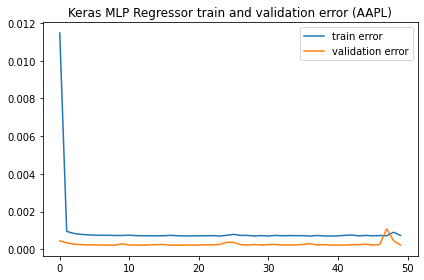

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 0.1163 - mean_squared_error: 0.1163
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 9.5061e-04 - mean_squared_error: 9.5061e-04
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 5.1032e-04 - mean_squared_error: 5.1032e-04
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 3.8522e-04 - mean_squared_error: 3.8522e-04
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 3.0143e-04 - mean_squared_error: 3.0143e-04
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 2.4638e-04 - mean_squared_error: 2.4638e-04
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 2.0955e-04 - mean_squared_error: 2.0955e-04
Epoch 8/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8523e-04 - mean_squared_error: 1.8523e-04
Epoch 9/50
56/56 [==============================] - 0s 2ms/step - loss: 1.6801e-

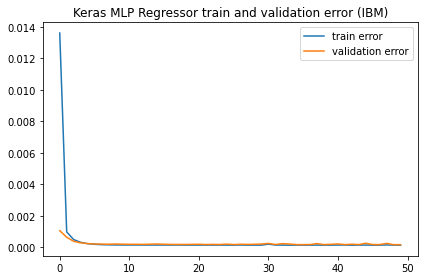

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 4.7593e-04 - mean_squared_error: 4.7593e-04
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 3.3582e-04 - mean_squared_error: 3.3582e-04
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 2.8154e-04 - mean_squared_error: 2.8154e-04
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 2.5535e-04 - mean_squared_error: 2.5535e-04
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 2.3716e-04 - mean_squared_error: 2.3716e-04
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 2.2690e-04 - mean_squared_error: 2.2690e-04
Epoch 8/50
56/56 [==============================] - 0s 2ms/step - loss: 2.2105e-04 - mean_squared_error: 2.2105e-04
Epoch 9/50
56/56 [==============================] - 0s 2ms/step - loss: 2.1537e-

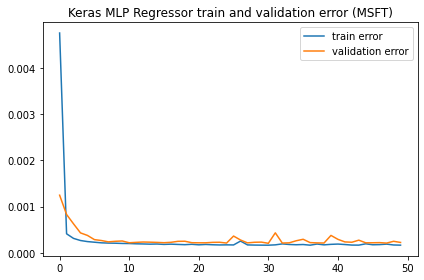

In [ ]:
#Keras Deep learning MLP model
def create_model(input_dim, optimizer='Adam'):

    # The optimal number of layers, neurons, and activation was obtain via a trial and error processes. Below is the optimal architecture that yielded the highest performance:
    model = Sequential()
    #first layer consists of 50 neurons
    model.add(Dense(100, input_dim=input_dim,activation = "sigmoid"))
    #second hidden layer consists of 20 neurons
    model.add(Dense(50,activation = "sigmoid"))
    #output layer 
    model.add(Dense(1,activation = "linear"))
    #compile the model
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError() , metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

STOCKS = Complete_DataFrame.index.get_level_values('TICKER').unique()

#making lists below to store performance metrics
mse_train_keras=[]
mse_test_keras=[]
Spr_keras=[]
cagr_train_keras=[]
cagr_test_keras=[]
ratio_train_keras=[]
ratio_test_keras=[]
dailyRet_train_keras=[]
dailyRet_test_keras=[]
df2_keras=[]
final_model_keras=[]

for i in STOCKS:
  df_keras=[]
  df_keras = Complete_DataFrame.loc[Complete_DataFrame.index.get_level_values('TICKER') == i]
  df1 = df_keras.copy(deep=True)

  #Train set- years 2011 to 2017
  X_train = df_keras[(df_keras.Year.isin([2011,2012,2013,2014,2015,2016,2017]))]

  #Validation set- years 2018 and 2019
  X_val = df_keras[(df_keras.Year.isin([2018,2019]))]

  #Test set- years 2020 to 2022
  X_test= df_keras[(df_keras.Year.isin([2020,2021,2022]))]

  Y_train = X_train['RetFut1']
  X_train.drop(['Year','RetFut1','OPENPRC'],axis=1,inplace=True)

  Y_test = X_test['RetFut1']
  X_test.drop(['Year','RetFut1','OPENPRC'],axis=1,inplace=True)

  Y_val = X_val['RetFut1']
  X_val.drop(['Year','RetFut1','OPENPRC'],axis=1,inplace=True)

  scaler2 = StandardScaler()

  X_train = scaler2.fit_transform(X_train)
  X_val = scaler2.transform(X_val)
  X_test = scaler2.transform(X_test)
  X_shape=X_train.shape[1]

  regressor = KerasRegressor(build_fn=create_model, epochs=50, batch_size=32,verbose=1)
  optimizer = ['Adadelta', 'Adam', 'Adamax', 'Nadam','SGD', 'RMSprop', 'Adagrad']

  gridsearch = GridSearchCV(estimator=regressor, param_grid=dict(input_dim=[X_shape], optimizer=optimizer), n_jobs=-1, cv=3)
  finalmodel_grid = gridsearch.fit(X_train, Y_train)

  print("Best: %f using %s" % (finalmodel_grid.best_score_, finalmodel_grid.best_params_))

  # Best Model

  best_model = Sequential()
  best_model.add(Dense(100, input_dim=X_shape,activation = "sigmoid"))
  best_model.add(Dense(50,activation = "sigmoid"))
  best_model.add(Dense(1,activation = "linear"))
  best_model.compile(optimizer=finalmodel_grid.best_params_['optimizer'], loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
  history = best_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, verbose=1)

  plt.title('Keras MLP Regressor train and validation error ({:s})'.format(i))
  plt.plot(history.history['loss'], label='train error')
  plt.plot(history.history['val_loss'], label='validation error')
  plt.legend()
  plt.tight_layout()
  plt.show()
  
  final_model_keras.append(best_model)

  #Get the train and test predictions
  train_preds = best_model.predict(X_train)
  test_preds = best_model.predict(X_test)

  positions_train = np.where(train_preds.ravel()> 0,1,-1 ) 
  positions_test = np.where(test_preds.ravel()> 0,1,-1 )

  #Get the daily returns
  dailyRet_train = pd.Series(positions_train).fillna(0).values * Y_train 
  dailyRet_test = pd.Series(positions_test).fillna(0).values * Y_test

  #Store results in a df to use for alpha lens evaluation
  Retpred = pd.concat([dailyRet_train,dailyRet_test])
  Retpred.name = 'RetPred'
  Retpred = pd.DataFrame(Retpred)
  df_keras=df1.join(Retpred,on = ['TICKER','date'], rsuffix='RetPred')
  df2_keras.append(df_keras)

  #daily returns of keras model
  dailyRet_train_keras.append(dailyRet_train) 
  dailyRet_test_keras.append(dailyRet_test)

  #cumulative returns
  cumret_train = np.cumprod(dailyRet_train +1) - 1   
  cumret_test = np.cumprod(dailyRet_test +1) - 1    

  # mean-squared error 
  mse_train=mean_squared_error(Y_train, dailyRet_train)
  mse_test=mean_squared_error(Y_test, dailyRet_test)

  mse_train_keras.append(mse_train)
  mse_test_keras.append(mse_test)

  # calculate Spearmann's rank coeff for each Asset and save
  S =stats.spearmanr(Y_test,test_preds.ravel())[0]   
  Spr_keras.append(S)

  # Compound Annual Growth Rate - Train
  cagr_train = (1 + cumret_test[-1]) ** (252 / len(cumret_test)) - 1
  cagr_train_keras.append(cagr_train)
      
  # Compound Annual Growth Rate - Test
  cagr_test = (1 + cumret_test[-1]) ** (252 / len(cumret_test)) - 1
  cagr_test_keras.append(cagr_test)
    
  # Sharpe Ratio - Training
  ratio_train = (252.0 ** (1.0/2.0)) * np.mean(dailyRet_train) / np.std(dailyRet_train)
  ratio_train_keras.append(ratio_train)
    
  # Sharpe Ratio - Test
  ratio_test = (252.0 ** (1.0/2.0)) * np.mean(dailyRet_test) / np.std(dailyRet_test)
  ratio_test_keras.append(ratio_test)

## 2. Displaying Statistical and Financial Performance Metrics:
Statistical metric:
- `Mean squared error`: gives the distance between actual and predicted points to determine how efficient a regression line is. 

- `Spearman Rank coefficient`:
Spearman's Rank correlation coefficient indicates the strength of relationship between two variables.

Financial metrics:
- `Compounded Annual Growth Rate(CAGR)`: CAGR is the smoothed rate of return that determines the growth of an investment from starting to ending balance. It is a good measure to evaluate multiple stocks against each other and how they perform over time. 

- `Sharpe ratio`:
Holding a risk asset makes the investment volatile leading to the investors expecting extra returns to compensated for the added risks. Sharpe ratio determines these excess returns. A ratio between 2 and 3 is very good while that greater than 3 is excellent. 


Lets evaluate the models on these metrics:

In [ ]:
#printing out the results
indexes =  ['MSE Train','MSE Test','CAGR Train','CAGR Test','Sharpe Ratio Train','Sharpe Ratio Test','Spearman Rank Coeff.']
columns =  ['AAPL', 'IBM', 'MSFT']
models = ['Random Forest Regressor','XGBoost Regressor','Extra Trees Regressor','LightGBM Regressor','Stacking Regressor','Keras MLP','Meta Prophet Model']

# getting the values of the metrics from the above function
rf_values  =  [randomforest_reg[6],randomforest_reg[7],randomforest_reg[8],randomforest_reg[9],randomforest_reg[10],randomforest_reg[11],randomforest_reg[3]]
xgb_values  =  [xgboost_reg[6],xgboost_reg[7],xgboost_reg[8],xgboost_reg[9],xgboost_reg[10],xgboost_reg[11],xgboost_reg[3]]
ext_values  =  [extremetrees_reg[6],extremetrees_reg[7],extremetrees_reg[8],extremetrees_reg[9],extremetrees_reg[10],extremetrees_reg[11],extremetrees_reg[3]]
lbgm_values  =  [lightgbm_reg[6],lightgbm_reg[7],lightgbm_reg[8],lightgbm_reg[9],lightgbm_reg[10],lightgbm_reg[11],lightgbm_reg[3]]
stck_values  =  [stack_reg[6],stack_reg[7],stack_reg[8],stack_reg[9],stack_reg[10],stack_reg[11],stack_reg[3]]
mlp_values  =  [mse_train_keras,mse_test_keras,cagr_train_keras,cagr_test_keras,ratio_train_keras,ratio_test_keras,Spr_keras]
prophet_values = [['NA','NA','NA'], mse_test_prophet, ['NA','NA','NA'],cagr_test_prophet,['NA','NA','NA'],ratio_test_prophet,Spr_prophet]

# making a dataframe of the above metrics
rf_df = pd.DataFrame(rf_values,columns=columns,index=indexes)
xgb_df = pd.DataFrame(xgb_values,columns=columns,index=indexes)
ext_df = pd.DataFrame(ext_values,columns=columns,index=indexes)
lbgm_df = pd.DataFrame(lbgm_values,columns=columns,index=indexes)
stck_df = pd.DataFrame(stck_values,columns=columns,index=indexes)
mlp_df = pd.DataFrame(mlp_values,columns=columns,index=indexes)
prophet_df = pd.DataFrame(prophet_values,columns=columns,index=indexes)

# concatenating the above df's and unstacking it
final_reg_df = pd.concat([rf_df,xgb_df,ext_df,lbgm_df,stck_df,mlp_df,prophet_df],keys=models)
final_reg = final_reg_df.unstack(level=1)

### 2.1 For Apple:


In [ ]:
final_reg.iloc[:,0:7]

AAPL                                 \
                        MSE Train  MSE Test CAGR Train CAGR Test   
Random Forest Regressor  0.001861  0.001046  18.164457  2.141055   
XGBoost Regressor        0.001839  0.000769  10.069471   2.77853   
Extra Trees Regressor    0.001714  0.000699   2.154292  2.650874   
LightGBM Regressor       0.001836   0.00495   7.988958  8.597191   
Stacking Regressor       0.001818  0.000757   9.156961  2.541166   
Keras MLP                0.002826  0.005895  -0.098965 -0.098965   
Meta Prophet Model             NA  0.000331         NA -0.430968   

                                                              \
                        Sharpe Ratio Train Sharpe Ratio Test   
Random Forest Regressor           8.666592          2.428482   
XGBoost Regressor                 6.763994          2.737232   
Extra Trees Regressor             3.115976          2.679325   
LightGBM Regressor                6.104409          4.006587   
Stacking Regressor                6.487964          2.628326   
Keras MLP                        -0.087787          0.078976   
Meta Prophet Model                      NA         -0.347253   

                                              
                        Spearman Rank Coeff.  
Random Forest Regressor              0.38054  
XGBoost Regressor                   0.384254  
Extra Trees Regressor               0.397255  
LightGBM Regressor                  0.398599  
Stacking Regressor                   0.38614  
Keras MLP                           0.339751  
Meta Prophet Model                  0.084369

Observations from the metrics:

- Prophet model performs the best in terms of MSE.
- The models are a good fit as the MSE for train and test sets are similar.
- CAGR does not account for the investment risks.  For large- scale companies like MSFT, IBM, CAGR of 5-12% is good . LightGBM regressor has highest test CAGR. The algorithm uses histogram-based splitting of data which generally leads to more accurate performances than other gradient boost algorithms.​
- A sharpe ratio between 2 and 3 is very good while that greater than 3 is excellent. Light GBM regressor has the highest test sharpe ratio. 
- The Spearman rank coefficient is similar for all models. 




### 2.2 For IBM:



In [ ]:
final_reg.iloc[:,7:14]

IBM                                 \
                        MSE Train  MSE Test CAGR Train CAGR Test   
Random Forest Regressor  0.000303  0.000626   6.264126  1.113365   
XGBoost Regressor        0.000301  0.000595    3.78285  1.447143   
Extra Trees Regressor    0.000258  0.000613   1.328855  1.245015   
LightGBM Regressor       0.000304  0.000614   2.607589  0.923023   
Stacking Regressor         0.0003  0.000601   5.466258  1.228514   
Keras MLP                0.000126   0.00037   0.847383  0.847383   
Meta Prophet Model             NA  0.000528         NA -0.142105   

                                                              \
                        Sharpe Ratio Train Sharpe Ratio Test   
Random Forest Regressor          14.310167          2.754523   
XGBoost Regressor                 9.913277          3.285415   
Extra Trees Regressor             4.789546          2.972564   
LightGBM Regressor                7.675459          2.417956   
Stacking Regressor               12.898864          2.945547   
Keras MLP                         3.452386          2.274659   
Meta Prophet Model                      NA         -0.379448   

                                              
                        Spearman Rank Coeff.  
Random Forest Regressor             0.254931  
XGBoost Regressor                   0.215929  
Extra Trees Regressor               0.254748  
LightGBM Regressor                  0.228967  
Stacking Regressor                  0.257599  
Keras MLP                           0.095077  
Meta Prophet Model                  0.016008

Observations from the metrics:

- Prophet model performs the best in terms of MSE.
- The models are a good fit as the MSE for train and test sets are similar.
- XG Boost regressor has highest test CAGR. 
- A sharpe ratio between 2 and 3 is very good while that greater than 3 is excellent. XG Boost Regressor gives an excellent test sharpe ratio. 
- The Spearman rank coefficient is very low for Prophet and MLP models. 




### 2.3 For Microsoft:



In [ ]:
final_reg.iloc[:,14:]

MSFT                                 \
                        MSE Train  MSE Test CAGR Train CAGR Test   
Random Forest Regressor  0.000365  0.000688   9.590916  4.822877   
XGBoost Regressor        0.000358  0.000543   6.365361   3.24093   
Extra Trees Regressor    0.000299  0.000696   2.034359  4.660547   
LightGBM Regressor       0.000354  0.000708   6.036191  4.555326   
Stacking Regressor       0.000362  0.000674    8.59629  4.361594   
Keras MLP                 0.00006  0.000887   0.447163  0.447163   
Meta Prophet Model             NA  0.000147         NA  0.179124   

                                                              \
                        Sharpe Ratio Train Sharpe Ratio Test   
Random Forest Regressor          14.393313          6.309601   
XGBoost Regressor                10.995097          5.078193   
Extra Trees Regressor             5.354984          6.195751   
LightGBM Regressor               10.632937          6.120705   
Stacking Regressor               13.360324          5.979715   
Keras MLP                         1.688907          1.356198   
Meta Prophet Model                      NA          0.689367   

                                              
                        Spearman Rank Coeff.  
Random Forest Regressor             0.457055  
XGBoost Regressor                   0.422406  
Extra Trees Regressor               0.449401  
LightGBM Regressor                  0.451076  
Stacking Regressor                  0.467926  
Keras MLP                           0.140199  
Meta Prophet Model                 -0.003162

Observations from the metrics:

- XG Boost regressor performs the best in terms of test MSE.
- The models are a good fit as the MSE for train and test sets are similar.
- All tree regressors have similar test CAGR and sharpe ratio. Random Forest regressor has marginally higher CAGR and sharpe ratio than the rest. 
- Light GBM regressor has the highest test sharpe ratio. 




To summarise, the trees models are a good fit for the model and have performed really well in terms of test MSE and sharpe ratio. The best models for the 3 stocks are as following:

Apple: Light GBM and Prophet

IBM: XG Boost and Prophet

Microsoft: Random forest and XG Boost

## 3. Train and Test Equity Curves for the Models

In [ ]:
def train_test_equity_curves(STOCK,dailyRet_train_model1,dailyRet_train_model2,dailyRet_train_model3,dailyRet_train_model4,dailyRet_train_model5,\
                             dailyRet_test_model1,dailyRet_test_model2,dailyRet_test_model3,dailyRet_test_model4,dailyRet_test_model5,dailyRet_test_model6,dailyRet_test_model7):
  
  df=[]
  all_cumrets_train=[]
  all_cumrets_test=[]
  df = Complete_DataFrame.loc[Complete_DataFrame.index.get_level_values('TICKER') == STOCK]
  
  df['RetFut1'] = df['OPENPRC'].pct_change(1).shift(-1).fillna(0)

  X_train = df[(df.Year.isin([2011,2012,2013,2014,2015,2016,2017,2018,2019]))]
  Y_train = X_train['RetFut1']
  X_train.drop(['Year','RetFut1','OPENPRC'],axis=1,inplace=True)

  X_test = df[(df.Year.isin([2020,2021,2022]))]
  Y_test = X_test['RetFut1']
  X_test.drop(['Year','RetFut1','OPENPRC'],axis=1,inplace=True)
  
  # Calculate Cross validated cumulative returns for train data based on daily returns obtained from the build model function above 
  cumret_train_model1 = np.cumprod(dailyRet_train_model1.values +1) - 1     
  cumret_train_model2 = np.cumprod(dailyRet_train_model2.values +1) - 1
  cumret_train_model3 = np.cumprod(dailyRet_train_model3.values +1) - 1
  cumret_train_model4 = np.cumprod(dailyRet_train_model4.values +1) - 1
  cumret_train_model5 = np.cumprod(dailyRet_train_model5.values +1) - 1

  #Append the Cross validated cumulative returns of all models to a list
  all_cumrets_train.append(cumret_train_model1)
  all_cumrets_train.append(cumret_train_model2)
  all_cumrets_train.append(cumret_train_model3)
  all_cumrets_train.append(cumret_train_model4)
  all_cumrets_train.append(cumret_train_model5)
  
  #Plotting the Cross validated cumulative returns for train set
  plt.figure(figsize=(10,5))
  sns.set(style="darkgrid")
  plt.plot(Y_train.index.get_level_values('date')[:500], cumret_train_model1[:500], label ='Random Forest Regressor')   
  plt.plot(Y_train.index.get_level_values('date')[:500], cumret_train_model2[:500], label = 'XGB Regressor')
  plt.plot(Y_train.index.get_level_values('date')[:500], cumret_train_model3[:500], label = 'Extra Trees Regressor')
  plt.plot(Y_train.index.get_level_values('date')[:500], cumret_train_model4[:500], label = 'LGBMRegressor')
  plt.plot(Y_train.index.get_level_values('date')[:500], cumret_train_model5[:500], label = 'Stacking Regressor')
  plt.title('Cross-validated cumulative returns on train set ' + STOCK)
  plt.ylabel('Cumulative Returns')
  plt.xlabel('Date')
  plt.xticks(Y_train[:500].index.get_level_values('date')[::40], rotation = 'vertical')
  plt.legend()
  plt.tight_layout()

  #Plot the Normalized Cross validated cumulative returns for train set
  plt.figure(figsize=(10,5))
  plt.plot(Y_train.index.get_level_values('date')[:500], np.average(np.vstack(list(all_cumrets_train)), axis=0)[:500],'--')
  plt.title('Normalized cumulative returns-train set ' + STOCK)
  plt.xticks(Y_train[:500].index.get_level_values('date')[::40], rotation = 'vertical')
  plt.ylabel('Cumulative Returns')
  plt.xlabel('Date')
  plt.tight_layout()

  # Calculate Cross validated cumulative returns for test data based on daily returns obtained from the build model function above 
  cumret_test_model1 = np.cumprod(dailyRet_test_model1.values +1) - 1
  cumret_test_model2 = np.cumprod(dailyRet_test_model2.values +1) - 1
  cumret_test_model3 = np.cumprod(dailyRet_test_model3.values +1) - 1
  cumret_test_model4 = np.cumprod(dailyRet_test_model4.values +1) - 1
  cumret_test_model5 = np.cumprod(dailyRet_test_model5.values +1) - 1
  cumret_test_model6 = np.cumprod(dailyRet_test_model6 +1) - 1
  cumret_test_model7 = np.cumprod(dailyRet_test_model7 +1) - 1

  #Append the Cross validated cumulative returns of all models to a list
  all_cumrets_test.append(cumret_test_model1)
  all_cumrets_test.append(cumret_test_model2)
  all_cumrets_test.append(cumret_test_model3)
  all_cumrets_test.append(cumret_test_model4)
  all_cumrets_test.append(cumret_test_model5)
  all_cumrets_test.append(cumret_test_model6)
  all_cumrets_test.append(cumret_test_model7)

  #Plot the Cross validated cumulative returns for train set
  plt.figure(figsize=(10,5))
  plt.plot(Y_test.index.get_level_values('date').values, cumret_test_model1, label ='Random Forest Regressor')   
  plt.plot(Y_test.index.get_level_values('date').values, cumret_test_model2, label = 'XGB Regressor')
  plt.plot(Y_test.index.get_level_values('date').values, cumret_test_model3, label = 'Extra Trees Regressor')
  plt.plot(Y_test.index.get_level_values('date').values, cumret_test_model4, label = 'LGBMRegressor')
  plt.plot(Y_test.index.get_level_values('date').values, cumret_test_model5, label = 'Stacking Regressor')
  plt.plot(Y_test.index.get_level_values('date').values, cumret_test_model6, label = 'Keras Regressor')
  plt.plot(Y_test.index.get_level_values('date').values, cumret_test_model7, label = 'Prophet model')
  plt.title('Cross-validated cumulative returns on test set ' + STOCK)
  plt.ylabel('Cumulative Returns')
  plt.xlabel('Date')
  plt.xticks(Y_test.index.get_level_values('date')[::30], rotation = 'vertical')
  plt.legend()
  plt.tight_layout()

  #Plot the Normalized Cross validated cumulative returns for test set
  plt.figure(figsize=(10,5))
  plt.plot(Y_test.index.get_level_values('date').values, np.average(np.vstack(list(all_cumrets_test)), axis=0),'--')
  plt.title('Normalized cumulative returns-test set ' + STOCK)
  plt.xticks(Y_test.index.get_level_values('date')[::30], rotation = 'vertical')
  plt.ylabel('Cumulative Returns')
  plt.xlabel('Date')
  plt.tight_layout()

### 3.1 For Apple:

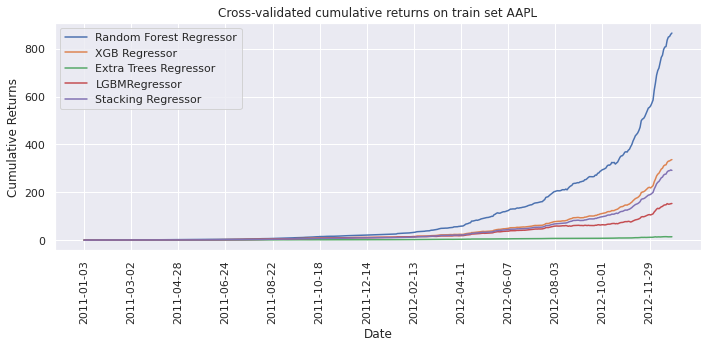

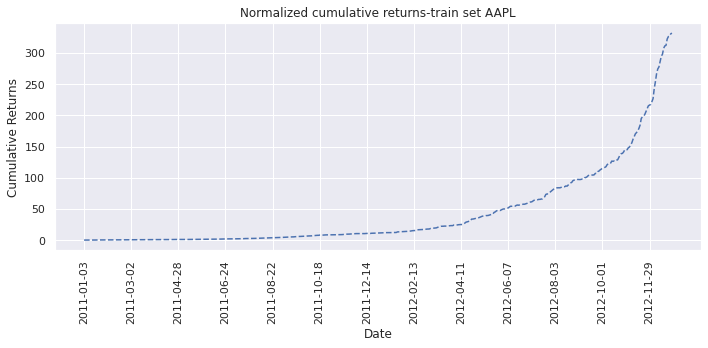

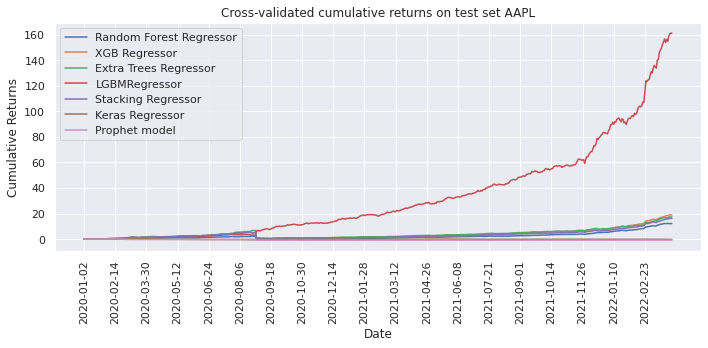

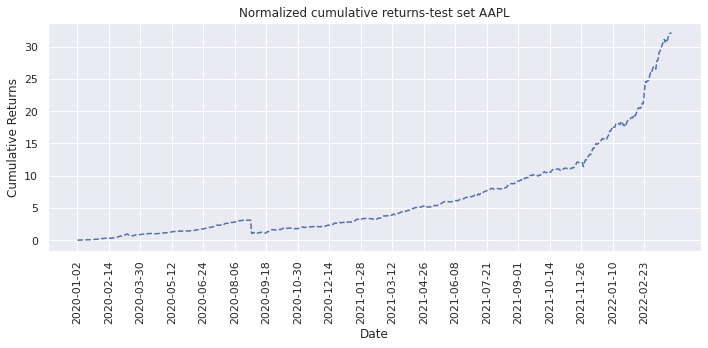

In [ ]:
train_test_equity_curves('AAPL',randomforest_reg[0][0],xgboost_reg[0][0],extremetrees_reg[0][0],lightgbm_reg[0][0],stack_reg[0][0],\
                         randomforest_reg[1][0],xgboost_reg[1][0],extremetrees_reg[1][0],lightgbm_reg[1][0],stack_reg[1][0],dailyRet_test_keras[0],dailyRet_test_prophet[0])

The returns of all models on test set are very low except LGBM which could possibly outperform the market. Rest all models have a very similar performance with cumulative returns not going above 20 over the 2 years in test set. The normalized cumulative return plot for test is a smooth and positive progressive curve.

### 3.2 For IBM:

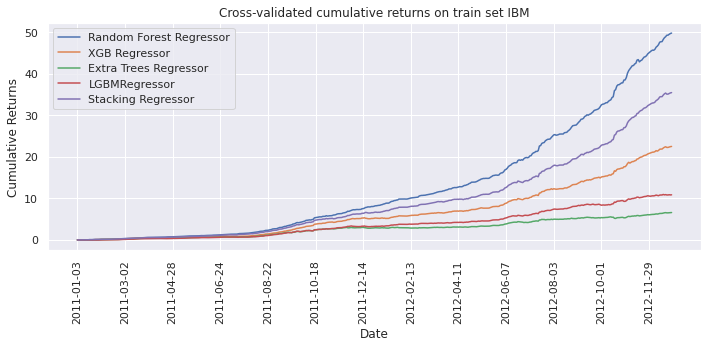

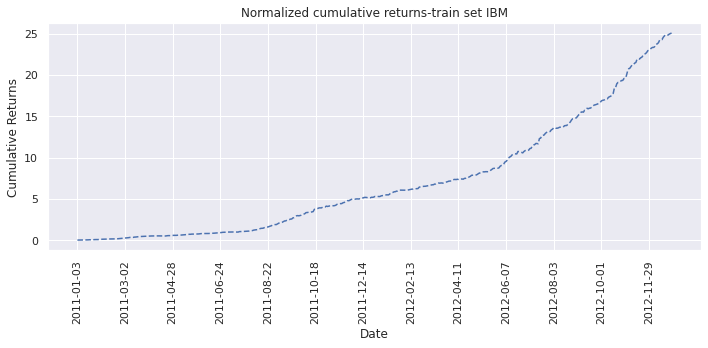

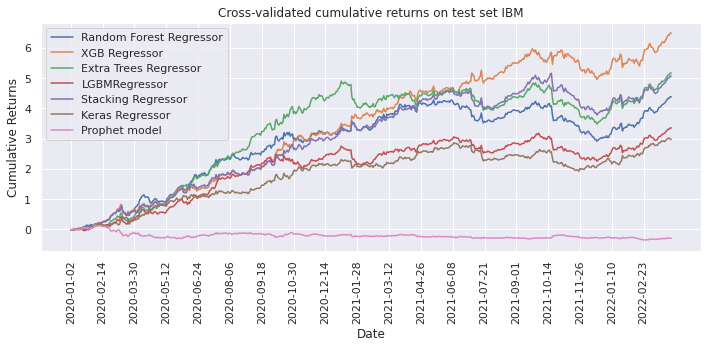

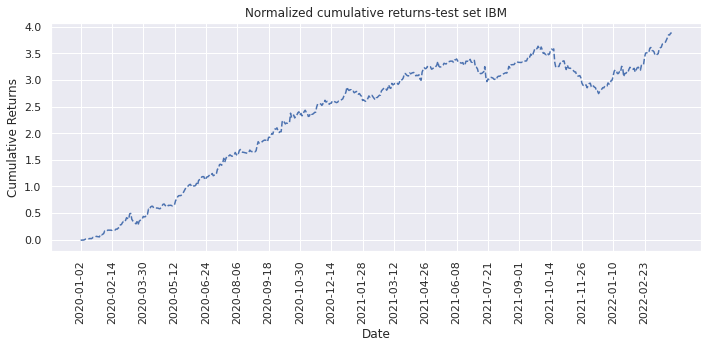

In [ ]:
train_test_equity_curves('IBM',randomforest_reg[0][1],xgboost_reg[0][1],extremetrees_reg[0][1],lightgbm_reg[0][1],stack_reg[0][1],\
                         randomforest_reg[1][1],xgboost_reg[1][1],extremetrees_reg[1][1],lightgbm_reg[1][1],stack_reg[1][1],dailyRet_test_keras[1],dailyRet_test_prophet[1])

Prophet model could not consistently outperform the market. Although the MSE is very low, its return predictions are lowest. XGB Regressor outperformed all other models having more volatile equity curve, followed by Extra Trees and Stacking Regressor. The models performed well as indicated in the normalized cumulative return plots with a smooth and positive progressive curve for both train & test data.

### 3.3 For Microsoft:

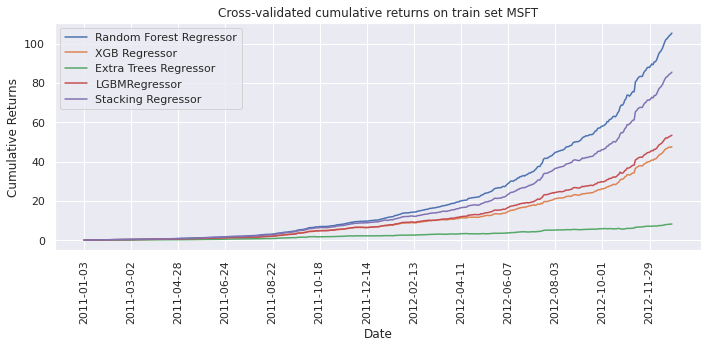

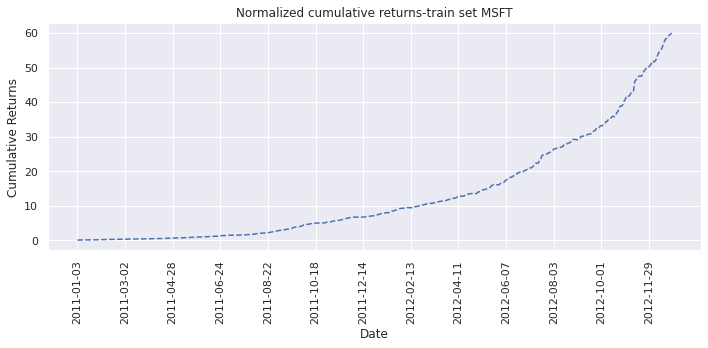

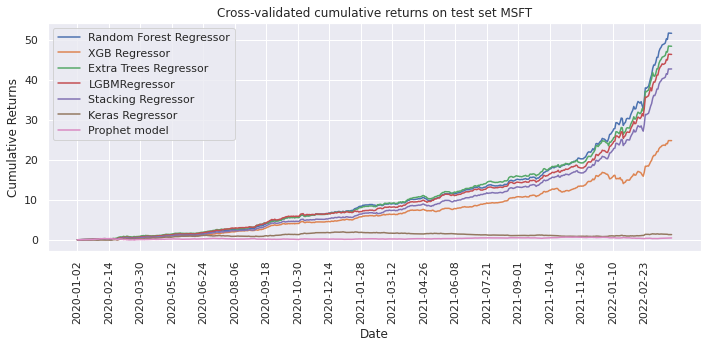

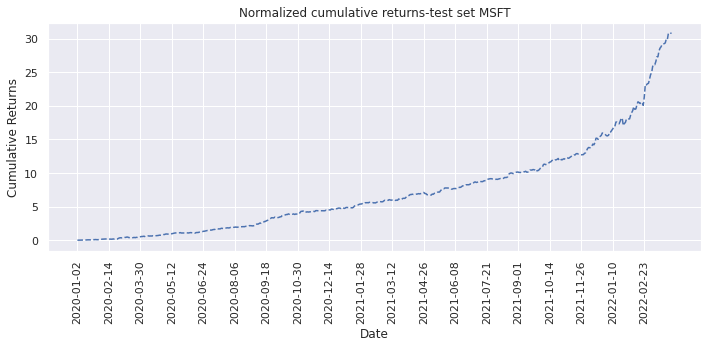

In [ ]:
train_test_equity_curves('MSFT',randomforest_reg[0][2],xgboost_reg[0][2],extremetrees_reg[0][2],lightgbm_reg[0][2],stack_reg[0][2],\
                         randomforest_reg[1][2],xgboost_reg[1][2],extremetrees_reg[1][2],lightgbm_reg[1][2],stack_reg[1][2],dailyRet_test_keras[2],dailyRet_test_prophet[2])

Keras MLP Regressor and Prophet models could not consistently outperform the market. Random Forest Regressor outperformed all other models having more volatile equity curve, followed by Extra Trees and Light GBM Regressor. The models performed well as indicated in the normalized cumulative return plots with a smooth and positive progressive curve for both train & test data.


# 4. Residual Distribution and Residual Autocorrelation plots for the models

Defining a function below to make these plots:

In [ ]:
def residual_plots(STOCK, best_model,modelname):

  print('Residual plots for', STOCK, 'with model', modelname)
  df=[]
  df = Complete_DataFrame.loc[Complete_DataFrame.index.get_level_values('TICKER') == STOCK]
  
  df['RetFut1'] = df['OPENPRC'].pct_change(1).shift(-1).fillna(0)
  X_test = df[(df.Year.isin([2020,2021,2022]))]
  Y_test = X_test['RetFut1']
  X_test.drop(['OPENPRC','Year','RetFut1'],axis=1,inplace=True)
  
  arr1 = Y_test.values.ravel() 
  arr2 = best_model.predict(X_test.values)

  residuals = np.subtract(arr1, arr2) #calculate the test residuals
  #Residual plots
  fig, axes = plt.subplots(ncols=2, figsize=(14,4))
  sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
  axes[0].set_title('Residual Distribution' )
  axes[0].legend()
  plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
  axes[1].set_xlabel('Lags')
  sns.despine()
  fig.tight_layout();
  plt.show()  

### 4.1 For Apple:

Residual plots for AAPL with model Random forest regressor


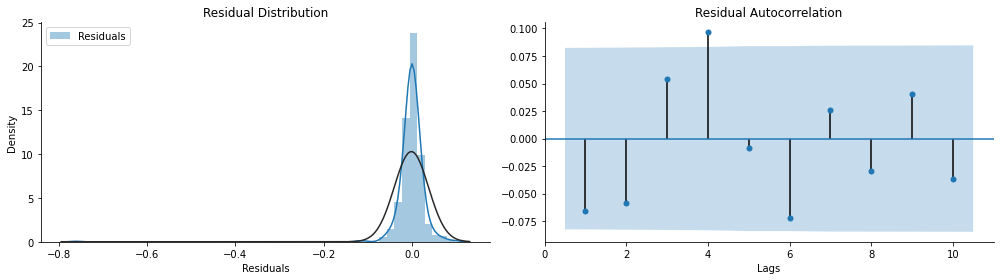

Residual plots for AAPL with model XGBoost regressor


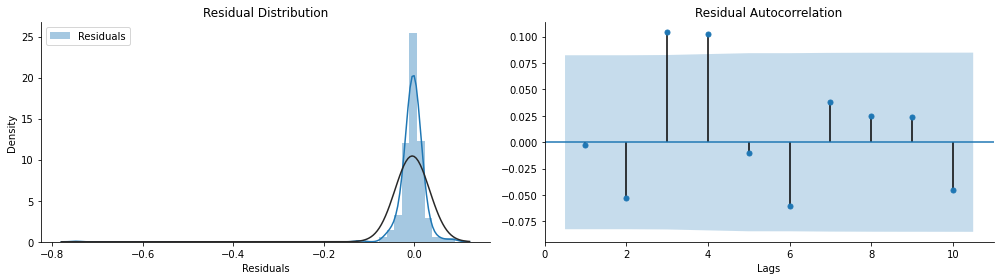

Residual plots for AAPL with model Extra trees regressor


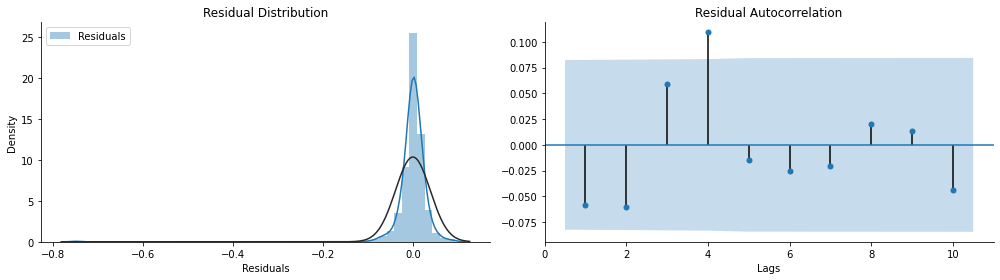

Residual plots for AAPL with model LightGBM regressor


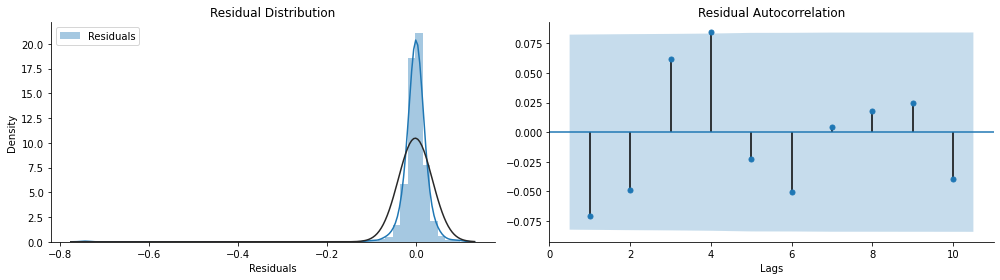

Residual plots for AAPL with model Stacking regressor


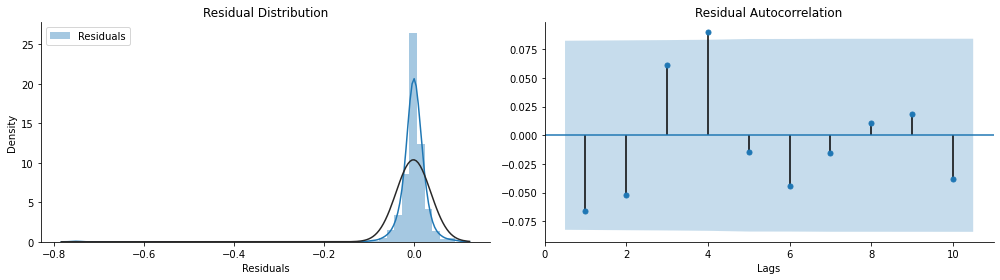

In [ ]:
residual_plots('AAPL',randomforest_reg[4][0],'Random forest regressor')
residual_plots('AAPL',xgboost_reg[4][0],'XGBoost regressor')
residual_plots('AAPL',extremetrees_reg[4][0],'Extra trees regressor')
residual_plots('AAPL',lightgbm_reg[4][0],'LightGBM regressor')
residual_plots('AAPL',stack_reg[4][0],'Stacking regressor')

### 4.2 For IBM:

Residual plots for IBM with model Random forest regressor


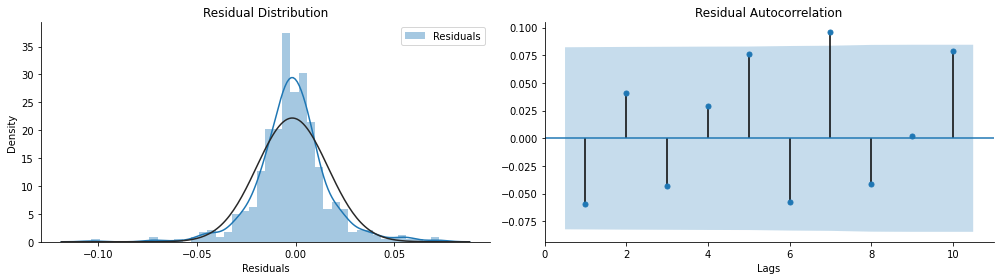

Residual plots for IBM with model XGBoost regressor


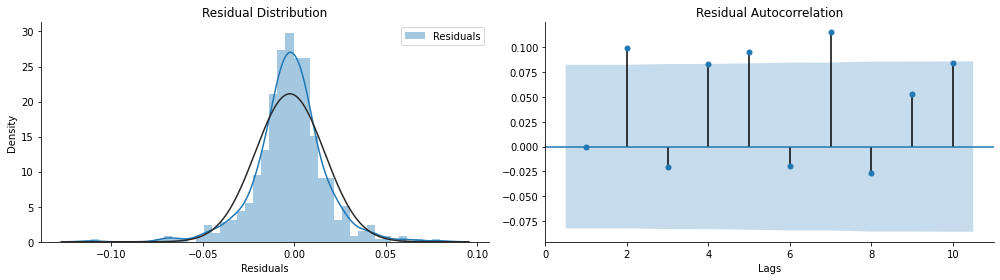

Residual plots for IBM with model Extra trees regressor


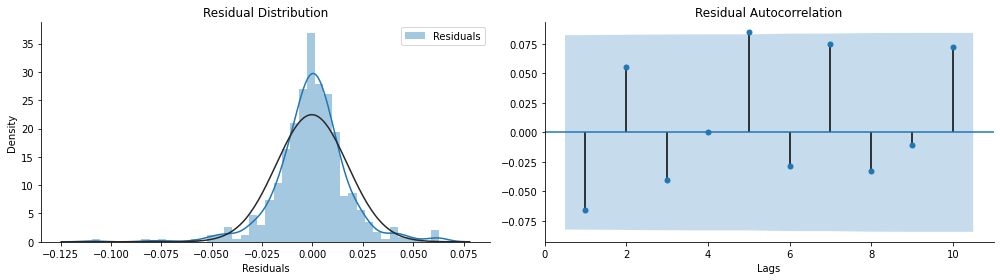

Residual plots for IBM with model LightGBM regressor


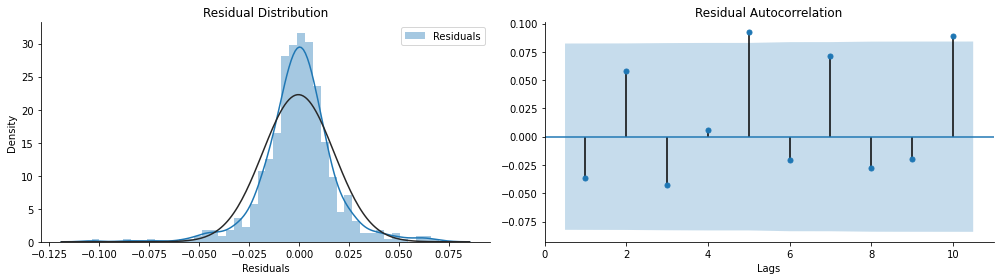

Residual plots for IBM with model Stacked regressor


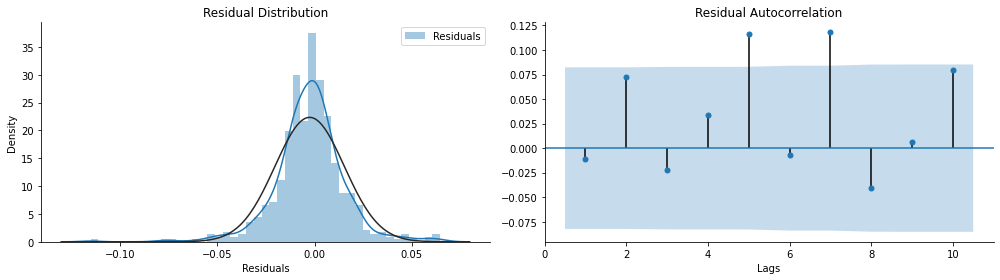

In [ ]:
residual_plots('IBM',randomforest_reg[4][1],'Random forest regressor')
residual_plots('IBM',xgboost_reg[4][1],'XGBoost regressor')
residual_plots('IBM',extremetrees_reg[4][1],'Extra trees regressor')
residual_plots('IBM',lightgbm_reg[4][1],'LightGBM regressor')
residual_plots('IBM',stack_reg[4][1],'Stacked regressor')

### 4.3 For Microsoft:

Residual plots for MSFT with model Random forest regressor


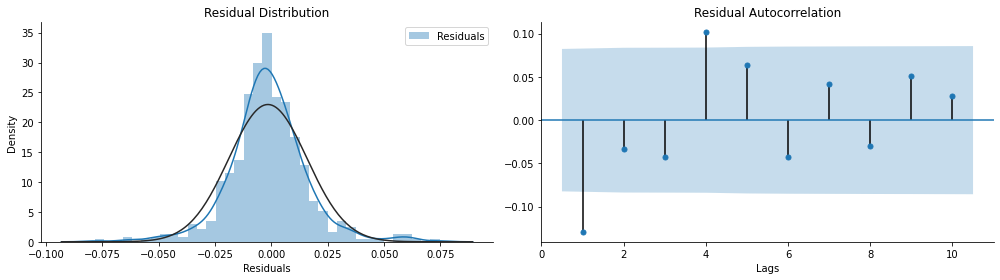

Residual plots for MSFT with model XGBoost regressor


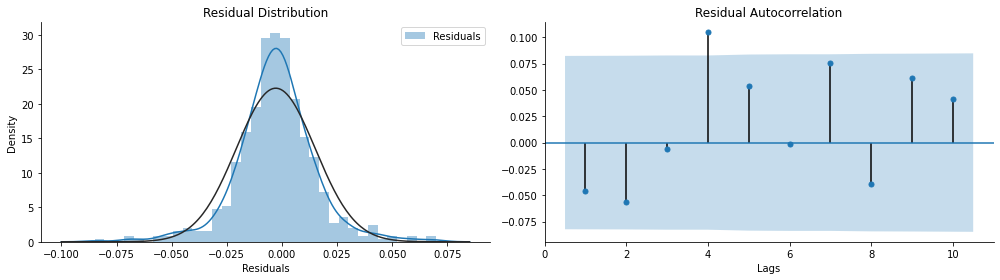

Residual plots for MSFT with model Extra trees regressor


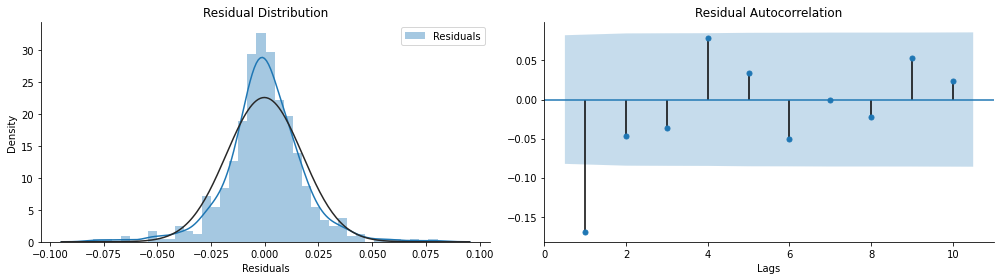

Residual plots for MSFT with model LightGBM regressor


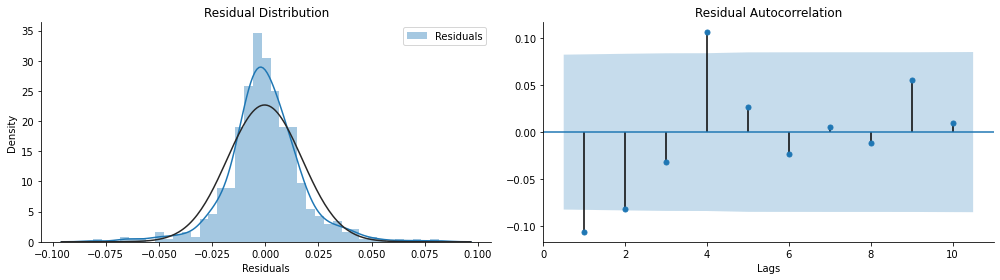

Residual plots for MSFT with model Stacked regressor


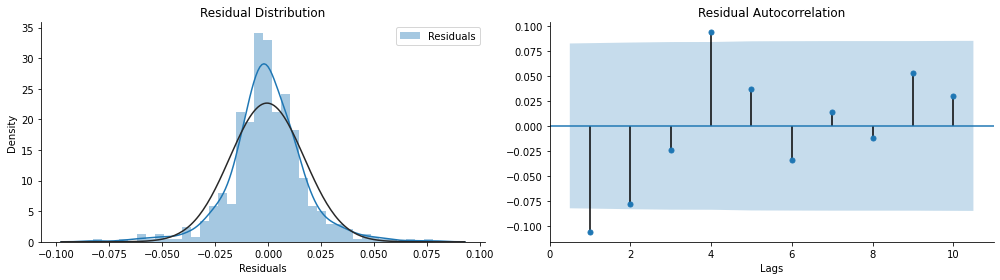

In [ ]:
residual_plots('MSFT',randomforest_reg[4][2],'Random forest regressor')
residual_plots('MSFT',xgboost_reg[4][2],'XGBoost regressor')
residual_plots('MSFT',extremetrees_reg[4][2],'Extra trees regressor')
residual_plots('MSFT',lightgbm_reg[4][2],'LightGBM regressor')
residual_plots('MSFT',stack_reg[4][2],'Stacked regressor')

For all 3 Stocks I can see that the residual density histogram plot is symmetric and normally distributed with a mean residual value of 0.0, indicating that the model's prediction align with the observed  value. The Residual Autocorrelation plot doesn’t show signs of any trends for all the 3 stocks indicating the fact that there is no scope of improving the model further as it is already predictions well. By observing the MSE values above, it is evident that MSE’s for all the models lies around 0.00 range. Hence, the residual plots are similar for all the models. 

## 5. Alpha Lens Evaluation

In [ ]:
def alphalens_evaluation(df2):
  df3=pd.concat(list(df2),ignore_index = False)   #combine all asset data into a DataFrame for Ahplalens
  df3.OPENPRC=Complete_DataFrame.OPENPRC
  df3.reset_index(inplace=True)
  df3.date=pd.to_datetime(df3.date)
  df3.set_index(["TICKER","date"], inplace=True)
  factor = pd.DataFrame(df3['RetPred'])
  factors = factor.swaplevel().tz_localize('EST', level='date').sort_index()
  factors = factors.drop_duplicates(keep='first')  #drop duplicates in index as Alphalens gives error with non-unique values
  factors = pd.DataFrame(factors)

  price = df3.pivot_table(index = 'date', columns = 'TICKER',values='OPENPRC')
  price.index = price.index.tz_localize('EST')
  #filter by test set dates to get the alpha lens results for those
  alpha_data = get_clean_factor_and_forward_returns(factor = factors.loc['2020-01-02':'2022-03-31'],
                                                      prices = price.loc['2020-01-02':'2022-03-31'],
                                                      quantiles=3,
                                                      periods=(1, 3, 5, 10, 21))
                                                    
  create_summary_tear_sheet(alpha_data)

### 5.1 For Random Forest Regressor:

Dropped 3.5% entries from factor data: 3.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.746890,0.075288,-0.007809,0.036432,546,33.394495
2,-0.086602,0.077328,0.006490,0.016060,543,33.211009
3,-0.050847,0.093877,0.017252,0.017924,546,33.394495


Returns Analysis


,1D,3D,5D,10D,21D
Ann. alpha,1.557,0.591,0.486,0.181,0.002
beta,-0.263,-0.369,-0.383,-0.195,0.013
Mean Period Wise Return Top Quantile (bps),34.227,14.376,12.430,3.227,-2.504
Mean Period Wise Return Bottom Quantile (bps),-40.433,-20.670,-18.712,-9.691,-2.991
Mean Period Wise Spread (bps),74.660,36.863,33.540,13.892,0.427


Information Analysis


,1D,3D,5D,10D,21D
IC Mean,0.314,0.136,0.154,0.054,0.002
IC Std.,0.879,0.733,0.735,0.720,0.719
Risk-Adjusted IC,0.357,0.185,0.209,0.075,0.003
t-stat(IC),8.352,4.319,4.890,1.753,0.059
p-value(IC),0.000,0.000,0.000,0.080,0.953
IC Skew,-0.656,-0.328,-0.339,-0.141,0.008
IC Kurtosis,-1.437,-1.422,-1.421,-1.496,-1.517


Turnover Analysis


,1D,3D,5D,10D,21D
Quantile 1 Mean Turnover,0.635,0.645,0.612,0.623,0.619
Quantile 2 Mean Turnover,0.635,0.617,0.658,0.623,0.690
Quantile 3 Mean Turnover,0.650,0.639,0.649,0.642,0.670


,1D,3D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.032,0.027,0.067,0.049,0.05


<Figure size 432x288 with 0 Axes>

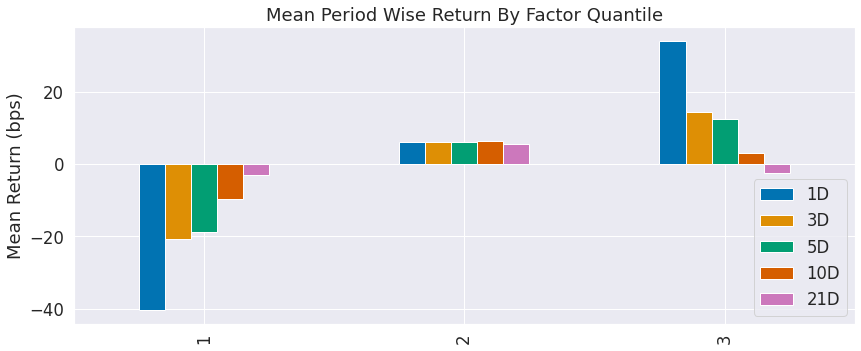

In [ ]:
alphalens_evaluation(randomforest_reg[5])

1st quantile             Most negative predictions. 

3rd quantile             Most positive predictions. 

Returns Analysis: 
- Alpha positive for all horizons-->returns are above market profits.
- Small Beta values-->stock is less volatile w.r.t market-portfolio's volatility. 

Information Analysis: 
- Preferred periods of stock holding with high IC: 1D and 5D 
- IC p-value: Indicates consistent profits over the first four periods.

### 5.2 For XGBoost Regressor:

Dropped 3.5% entries from factor data: 3.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.746890,0.075288,-0.008066,0.036272,546,33.374083
2,-0.086602,0.084640,0.006353,0.015962,544,33.251834
3,-0.050847,0.097256,0.017644,0.017874,546,33.374083


Returns Analysis


,1D,3D,5D,10D,21D
Ann. alpha,2.196,0.440,0.254,0.032,-0.019
beta,-0.269,-0.093,0.009,0.087,0.109
Mean Period Wise Return Top Quantile (bps),41.094,15.193,11.253,0.870,-2.381
Mean Period Wise Return Bottom Quantile (bps),-52.514,-12.403,-7.734,-2.370,-1.141
Mean Period Wise Spread (bps),93.608,28.152,18.861,2.324,-1.796


Information Analysis


,1D,3D,5D,10D,21D
IC Mean,0.366,0.128,0.149,0.076,0.024
IC Std.,0.823,0.735,0.731,0.716,0.717
Risk-Adjusted IC,0.445,0.175,0.204,0.106,0.033
t-stat(IC),10.399,4.079,4.768,2.480,0.776
p-value(IC),0.000,0.000,0.000,0.013,0.438
IC Skew,-0.766,-0.268,-0.325,-0.189,-0.016
IC Kurtosis,-1.197,-1.467,-1.425,-1.472,-1.515


Turnover Analysis


,1D,3D,5D,10D,21D
Quantile 1 Mean Turnover,0.631,0.672,0.621,0.677,0.670
Quantile 2 Mean Turnover,0.626,0.656,0.636,0.612,0.669
Quantile 3 Mean Turnover,0.677,0.646,0.638,0.672,0.667


,1D,3D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.004,0.012,0.058,-0.035,-0.006


<Figure size 432x288 with 0 Axes>

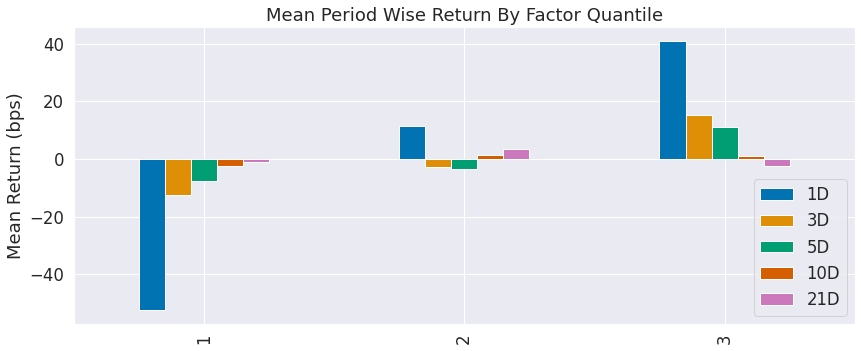

In [ ]:
alphalens_evaluation(xgboost_reg[5])

1st quantile           Most negative predictions. 

3rd quantile           Most positive predictions. 

Returns Analysis: 
- Returns are above market profits, and the stock can easily outperform market for first four horizons. 
- Stock's volatility is very low for all holdings except 1D. 

Information Analysis: 
- Preferred periods of stock holding with high IC:3D and 5D. 
- IC p-value < 0.05 indicates consistent profits over the first four periods.

### 5.3 For Extra trees Regressor:

Dropped 3.5% entries from factor data: 3.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.746890,0.075288,-0.007349,0.036265,546,33.394495
2,-0.086602,0.084640,0.006682,0.016256,543,33.211009
3,-0.050847,0.097256,0.017302,0.018158,546,33.394495


Returns Analysis


,1D,3D,5D,10D,21D
Ann. alpha,2.417,0.568,0.398,0.140,0.005
beta,-0.253,-0.259,-0.213,-0.110,-0.014
Mean Period Wise Return Top Quantile (bps),46.353,16.651,11.282,2.633,-2.079
Mean Period Wise Return Bottom Quantile (bps),-51.339,-15.586,-12.116,-6.431,-1.362
Mean Period Wise Spread (bps),97.692,33.478,23.890,8.975,-1.106


Information Analysis


,1D,3D,5D,10D,21D
IC Mean,0.392,0.150,0.150,0.063,0.008
IC Std.,0.864,0.738,0.740,0.731,0.713
Risk-Adjusted IC,0.454,0.204,0.203,0.086,0.012
t-stat(IC),10.603,4.756,4.744,2.020,0.270
p-value(IC),0.000,0.000,0.000,0.044,0.787
IC Skew,-0.846,-0.341,-0.348,-0.153,-0.018
IC Kurtosis,-1.169,-1.424,-1.421,-1.509,-1.507


Turnover Analysis


,1D,3D,5D,10D,21D
Quantile 1 Mean Turnover,0.670,0.621,0.625,0.627,0.632
Quantile 2 Mean Turnover,0.640,0.646,0.658,0.640,0.674
Quantile 3 Mean Turnover,0.655,0.617,0.647,0.675,0.661


,1D,3D,5D,10D,21D
Mean Factor Rank Autocorrelation,-0.006,0.083,0.057,0.021,0.047


<Figure size 432x288 with 0 Axes>

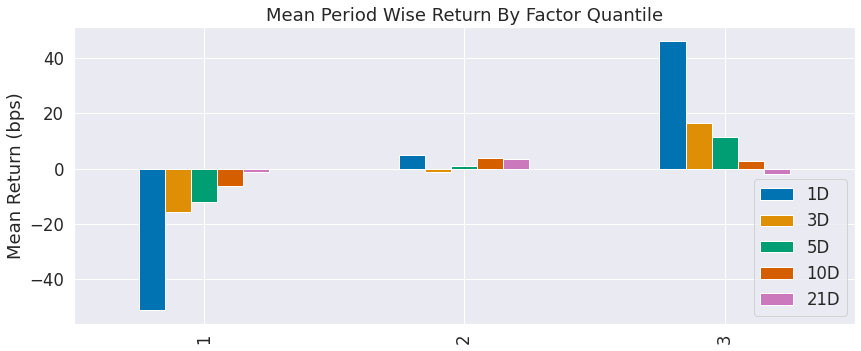

In [ ]:
alphalens_evaluation(extremetrees_reg[5])

1st quantile             Most negative predictions. 

3rd quantile             Most positive predictions. 

Returns Analysis: 
- Alpha positive for all horizons-->returns are above market profits.
- Small Beta values-->stock is less volatile w.r.t market-portfolio's volatility. 

Information Analysis: 
- Preferred periods of stock holding with high IC: 5D and 10D
- IC p-value: Indicates consistent profits over the first four periods.

### 5.4 For Light GBM regressor:

Dropped 3.5% entries from factor data: 3.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.098270,0.075288,-0.005995,0.018186,546,33.394495
2,-0.086602,0.077328,0.006615,0.016183,543,33.211009
3,-0.050847,0.746890,0.018552,0.035925,546,33.394495


Returns Analysis


,1D,3D,5D,10D,21D
Ann. alpha,0.587,0.204,0.218,0.135,0.050
beta,0.582,0.182,0.063,-0.082,-0.072
Mean Period Wise Return Top Quantile (bps),21.025,7.190,6.796,3.601,0.156
Mean Period Wise Return Bottom Quantile (bps),-25.603,-9.705,-9.479,-5.073,-3.022
Mean Period Wise Spread (bps),46.628,16.504,15.469,8.889,3.345


Information Analysis


,1D,3D,5D,10D,21D
IC Mean,0.332,0.149,0.140,0.044,0.034
IC Std.,0.867,0.748,0.737,0.731,0.725
Risk-Adjusted IC,0.382,0.200,0.190,0.060,0.047
t-stat(IC),8.936,4.662,4.442,1.405,1.092
p-value(IC),0.000,0.000,0.000,0.161,0.275
IC Skew,-0.688,-0.337,-0.315,-0.138,-0.093
IC Kurtosis,-1.381,-1.446,-1.441,-1.516,-1.517


Turnover Analysis


,1D,3D,5D,10D,21D
Quantile 1 Mean Turnover,0.662,0.648,0.606,0.603,0.625
Quantile 2 Mean Turnover,0.659,0.635,0.632,0.651,0.661
Quantile 3 Mean Turnover,0.677,0.643,0.647,0.649,0.653


,1D,3D,5D,10D,21D
Mean Factor Rank Autocorrelation,-0.012,0.026,0.063,0.076,0.05


<Figure size 432x288 with 0 Axes>

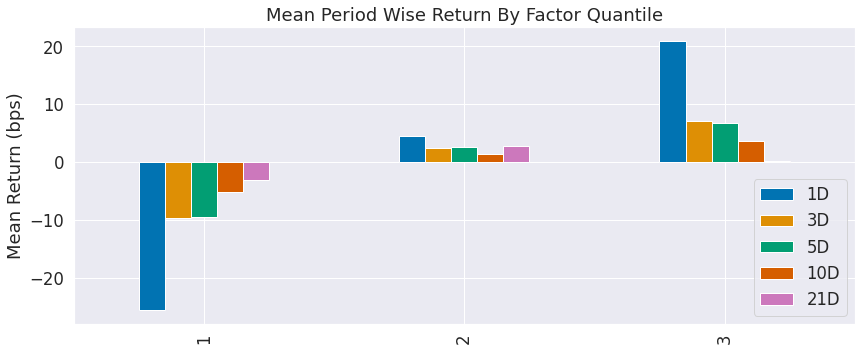

In [ ]:
alphalens_evaluation(lightgbm_reg[5])

1st quantile             Most negative predictions. 

3rd quantile             Most positive predictions. 

Returns Analysis: 
- Alpha positive for all horizons-->returns are above market profits.
- Small Beta values for all except 1D-->stock is less volatile w.r.t market-portfolio's volatility. 

Information Analysis: 
- Preferred periods of stock holding with high IC: 5D Aand 10D

### 5.5 For Stacking Ensemble:

Dropped 3.5% entries from factor data: 3.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.746890,0.075288,-0.007528,0.036252,546,33.394495
2,-0.086602,0.084640,0.006219,0.016201,543,33.211009
3,-0.050847,0.097256,0.017536,0.018102,546,33.394495


Returns Analysis


,1D,3D,5D,10D,21D
Ann. alpha,2.345,0.538,0.445,0.121,-0.015
beta,-0.249,-0.097,-0.163,-0.010,0.107
Mean Period Wise Return Top Quantile (bps),45.893,18.196,16.200,3.657,-1.996
Mean Period Wise Return Bottom Quantile (bps),-52.270,-14.574,-12.884,-5.370,-1.249
Mean Period Wise Spread (bps),98.163,33.330,30.003,8.656,-1.261


Information Analysis


,1D,3D,5D,10D,21D
IC Mean,0.393,0.168,0.182,0.103,0.013
IC Std.,0.843,0.724,0.718,0.720,0.719
Risk-Adjusted IC,0.466,0.232,0.254,0.143,0.018
t-stat(IC),10.887,5.411,5.929,3.330,0.417
p-value(IC),0.000,0.000,0.000,0.001,0.677
IC Skew,-0.847,-0.383,-0.406,-0.214,-0.015
IC Kurtosis,-1.125,-1.366,-1.338,-1.469,-1.517


Turnover Analysis


,1D,3D,5D,10D,21D
Quantile 1 Mean Turnover,0.637,0.641,0.610,0.666,0.648
Quantile 2 Mean Turnover,0.625,0.635,0.639,0.645,0.697
Quantile 3 Mean Turnover,0.657,0.628,0.656,0.666,0.674


,1D,3D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.017,0.047,0.053,-0.004,0.021


<Figure size 432x288 with 0 Axes>

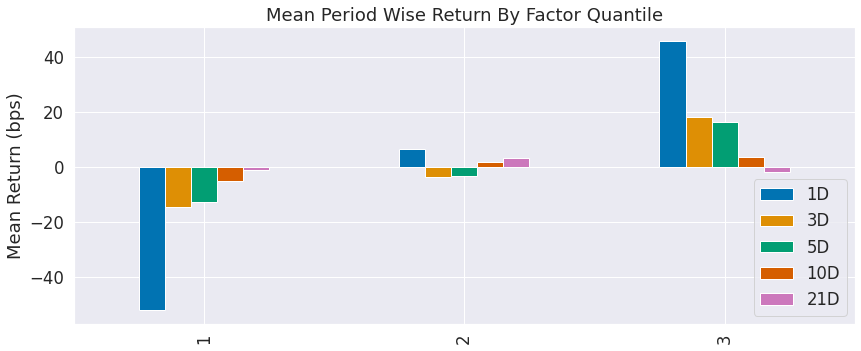

In [ ]:
alphalens_evaluation(stack_reg[5])

Returns Analysis: 
- Returns are above market profits, and the stock can easily outperform market for first four horizons. 
- Stock is less volatile w.r.t market-portfolio's volatility. 
- 1D Stock Holding--> Highest volatility and returns. 

Information Analysis: 
- Preferred periods of stock holding with high IC:1D, 3D and 5D 
- IC p-value < 0.05 indicates consistent profits over the first four periods.

### 5.6 For Keras MLP Regressor:

Dropped 3.5% entries from factor data: 3.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.746890,0.075288,-0.011203,0.036094,546,33.394495
2,-0.086602,0.084640,0.004360,0.016068,543,33.211009
3,-0.050847,0.097256,0.017078,0.017600,546,33.394495


Returns Analysis


,1D,3D,5D,10D,21D
Ann. alpha,3.384,0.709,0.447,0.096,-0.004
beta,-0.315,-0.224,-0.247,-0.027,0.079
Mean Period Wise Return Top Quantile (bps),55.555,19.293,13.446,1.251,-2.313
Mean Period Wise Return Bottom Quantile (bps),-61.851,-21.197,-14.012,-6.010,-2.210
Mean Period Wise Spread (bps),117.407,41.635,28.902,7.177,-0.399


Information Analysis


,1D,3D,5D,10D,21D
IC Mean,0.503,0.197,0.156,0.081,0.014
IC Std.,0.709,0.718,0.723,0.721,0.722
Risk-Adjusted IC,0.709,0.274,0.215,0.112,0.019
t-stat(IC),16.576,6.406,5.028,2.613,0.445
p-value(IC),0.000,0.000,0.000,0.009,0.657
IC Skew,-1.124,-0.417,-0.364,-0.136,-0.044
IC Kurtosis,-0.331,-1.332,-1.379,-1.503,-1.519


Turnover Analysis


,1D,3D,5D,10D,21D
Quantile 1 Mean Turnover,0.681,0.670,0.702,0.649,0.684
Quantile 2 Mean Turnover,0.661,0.669,0.660,0.662,0.648
Quantile 3 Mean Turnover,0.659,0.650,0.675,0.649,0.676


,1D,3D,5D,10D,21D
Mean Factor Rank Autocorrelation,-0.006,0.012,-0.047,0.035,-0.039


<Figure size 432x288 with 0 Axes>

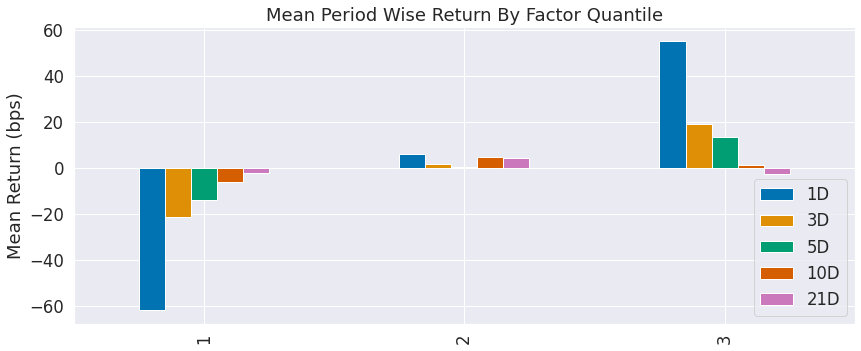

In [ ]:
alphalens_evaluation(df2_keras)

1st quantile             Most negative predictions. 

3rd quantile             Most positive predictions. 

Returns Analysis: 
- Stock can outperform market
- Small Beta values-->stock is less volatile w.r.t market-portfolio's volatility. 

Information Analysis: 
- Preferred periods of stock holding with high IC: 1D and 5D 
- IC p-value: Indicates consistent profits over the first four periods.

## 6. SHAP Plots

I decided to use Shap plots in this project to better understand why models behave and perfrom they way they do. Shap plots are used to increase model’s transparency and interpretability and make the models seem like less of a black box.

In [ ]:
def shap_plot(best_model,STOCK): 
  df = Complete_DataFrame.loc[Complete_DataFrame.index.get_level_values('TICKER') == STOCK]
  X_train = df[(df.Year.isin([2011,2012,2013,2014,2015,2016,2017,2018,2019]))]
  Y_train = X_train['RetFut1']
  X_train.drop(['Year','RetFut1','OPENPRC'],axis=1,inplace=True)

  X_test = df[(df.Year.isin([2020,2021,2022]))]
  Y_test = X_test['RetFut1']
  X_test.drop(['Year','RetFut1','OPENPRC'],axis=1,inplace=True)
  median = X_train.median().values.reshape((1,X_train.shape[1]))
  explainer = shap.KernelExplainer(best_model.predict, median)
  shap_values = explainer.shap_values(X_test)#, nsamples=100)

  print('--------------------------------------')
  print('Shap plot for ',STOCK)
  print('--------------------------------------')

  shap.summary_plot(shap_values, X_test, show=False)
  plt.title('Shap summary plot for ({:s})'.format(STOCK))
  plt.show()

## 6.1 For Random Forest Regressor:

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  AAPL
--------------------------------------


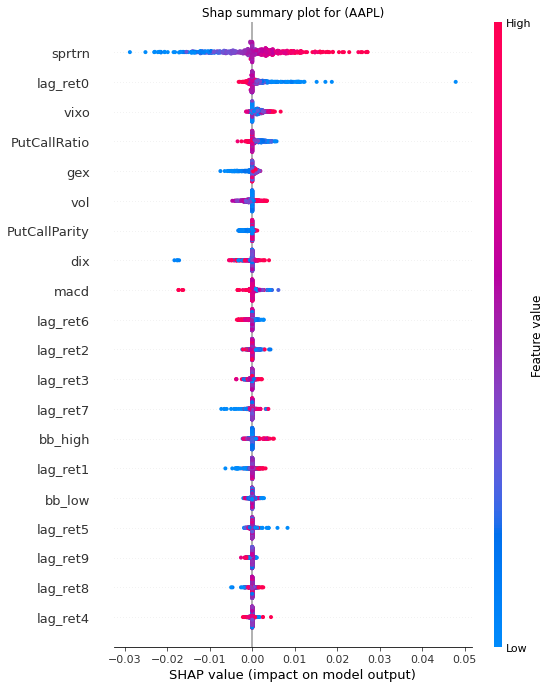

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  IBM
--------------------------------------


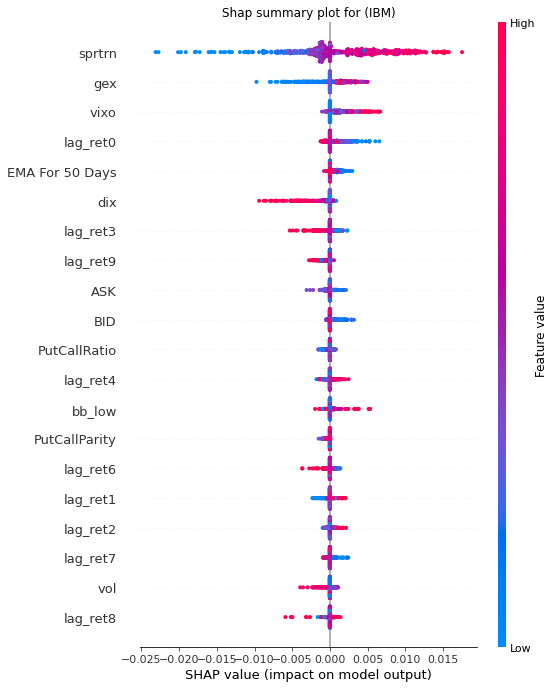

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  MSFT
--------------------------------------


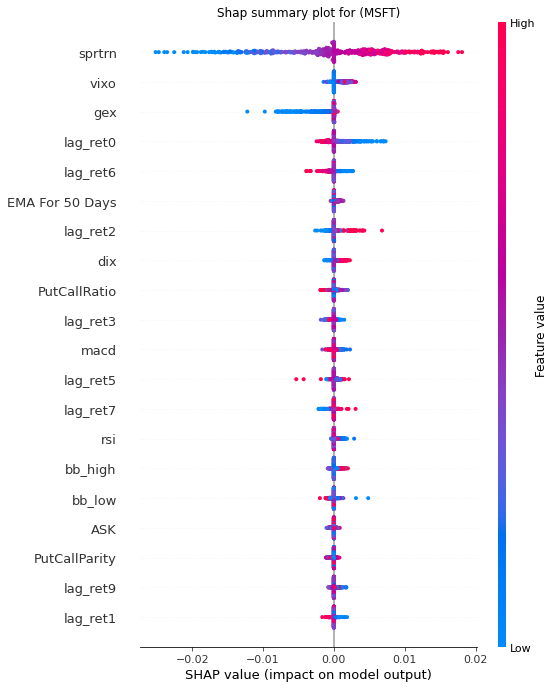

In [ ]:
shap_plot(randomforest_reg[4][0],'AAPL')
shap_plot(randomforest_reg[4][1],'IBM')
shap_plot(randomforest_reg[4][2],'MSFT')

The Shap summary plot for the Random Forest Regressor can be seen above. 

Each instance in the dataset represents a point on the Shap plot. The plot provides the following information: 

 - Feature importance, ranked from highest (most important) to lowest (least important). 
 - Horizontal axis represents the impact of each instance. 
 - Color represents if the feature was high (red) or low (blue) for that instance in the sample.

The Shap plot indicates that "sprtrn" variable is the most important feature when making predictions. Features that have high influence on the model is "sprtrn”, "vixo", and "gex” illustrating that the model is heavily influenced by the general market behavior in contrast to single stock conditions. 

This may be the reason why the model is performing exceptionally (MSE = 0.000688).

### 6.2 For Extra Trees Regressor:

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  AAPL
--------------------------------------


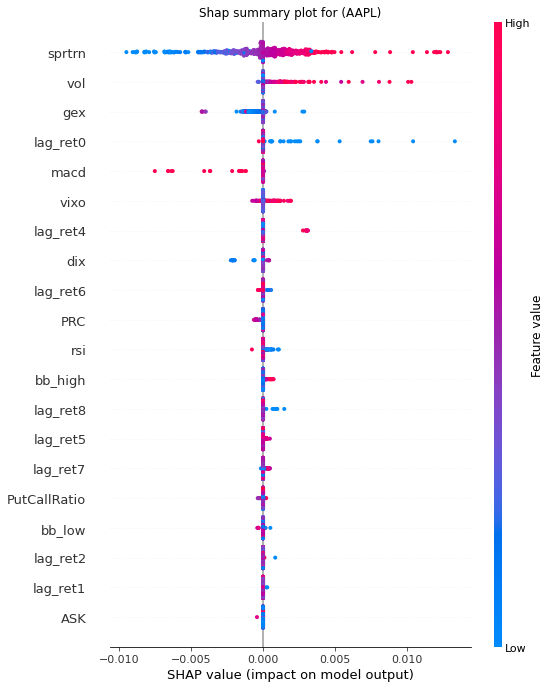

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  IBM
--------------------------------------


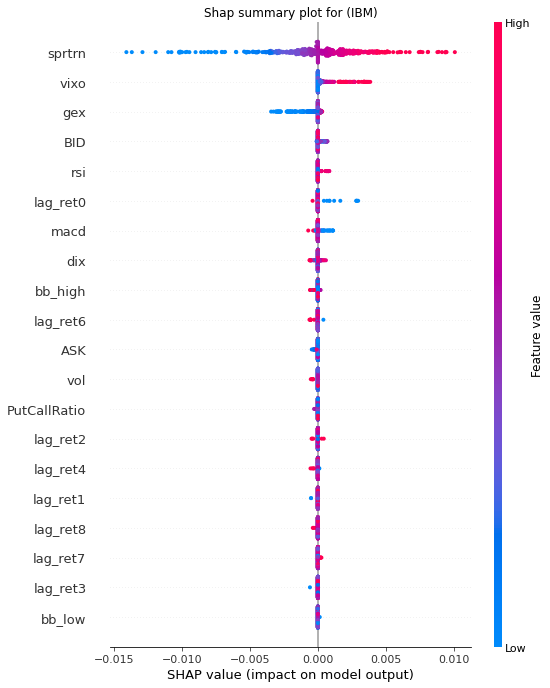

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  MSFT
--------------------------------------


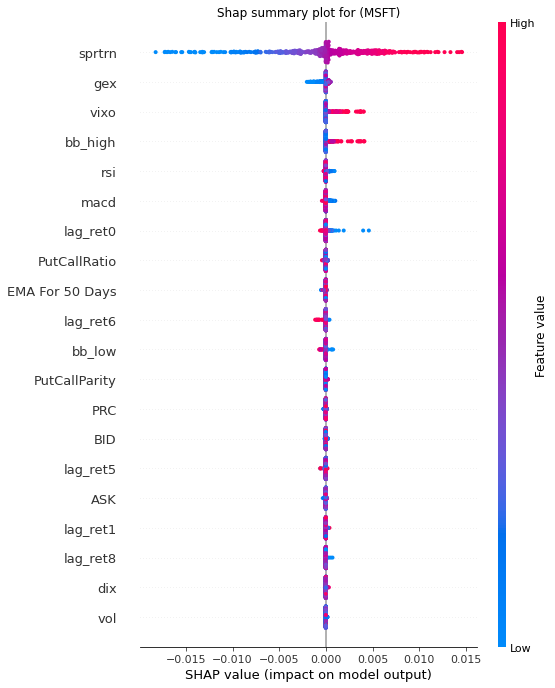

In [ ]:
shap_plot(extremetrees_reg[4][0],'AAPL')
shap_plot(extremetrees_reg[4][1],'IBM')
shap_plot(extremetrees_reg[4][2],'MSFT')

The Shap plot indicates that "sprtrn" variable is the most important feature when making predictions for all three assests.

For assest such as Microsoft and IBM, the model seems to be primarily influenced by the general market and not individual stocks, however, for Apple the model predictions is influenced by single stock conditions in addition to the general market behavior.

### 6.3 For XGBoost Regressor:

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  AAPL
--------------------------------------


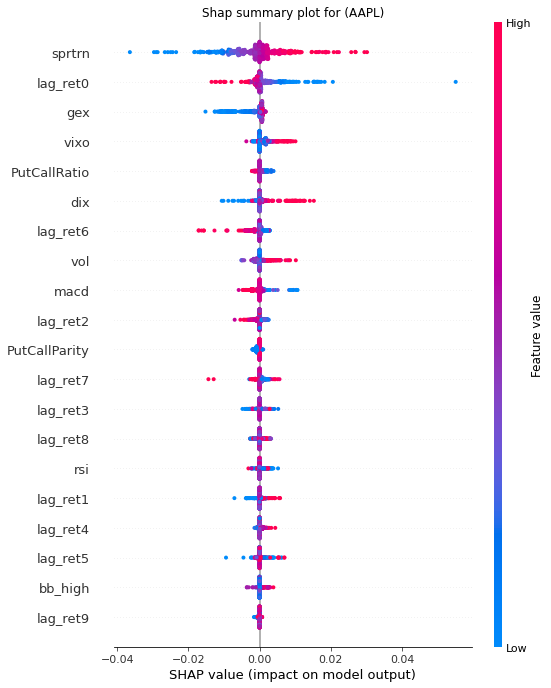

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  IBM
--------------------------------------


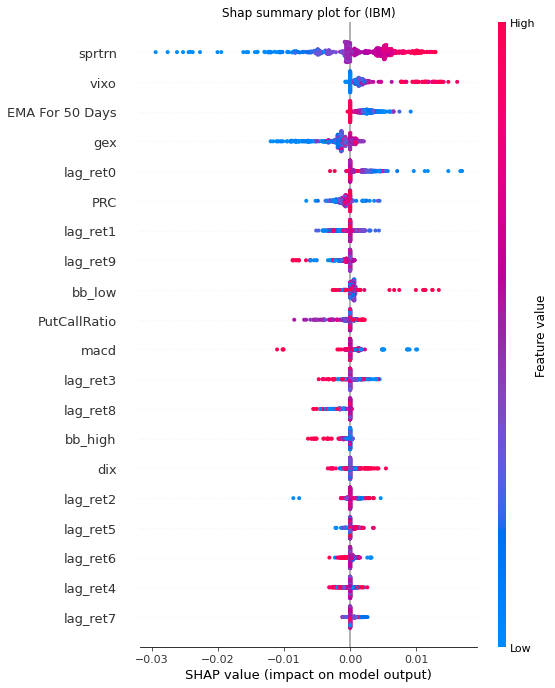

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  MSFT
--------------------------------------


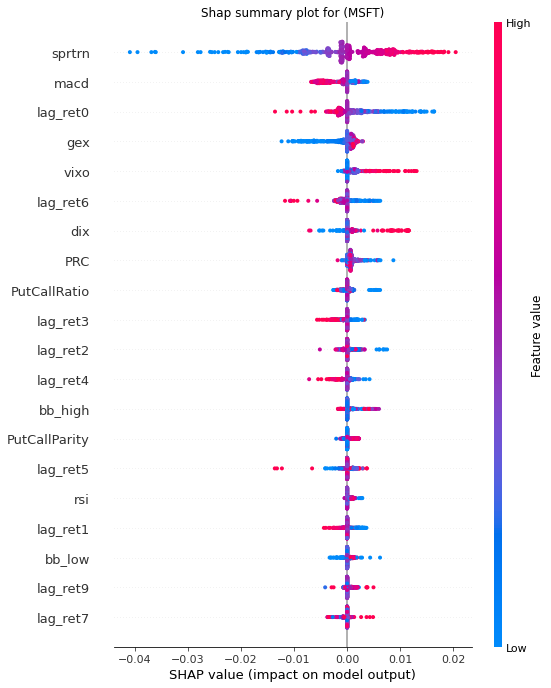

In [ ]:
shap_plot(xgboost_reg[4][0],'AAPL')
shap_plot(xgboost_reg[4][1],'IBM')
shap_plot(xgboost_reg[4][2],'MSFT')

The Shap plot indicates that "sprtrn" variable is the most important feature when making predictions. 

All features contribute to the model’s decision making. 

Model predictions is influenced by single stock conditions in addition to the general market behavior. 

This may be indicative on why the model is performing exceptionally (MSE = 0.000769). 

The high (red) and low (blue) values are clearly defined, with no overlapping w.r.t Shap values. This leads to the model making definite predictions since no inconsistency will exist between the features.

### 6.4 For Stacking Regressor:

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  AAPL
--------------------------------------


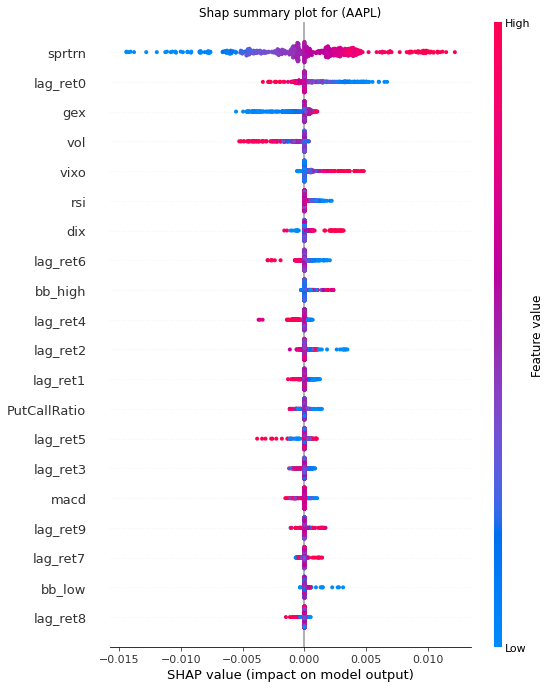

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  IBM
--------------------------------------


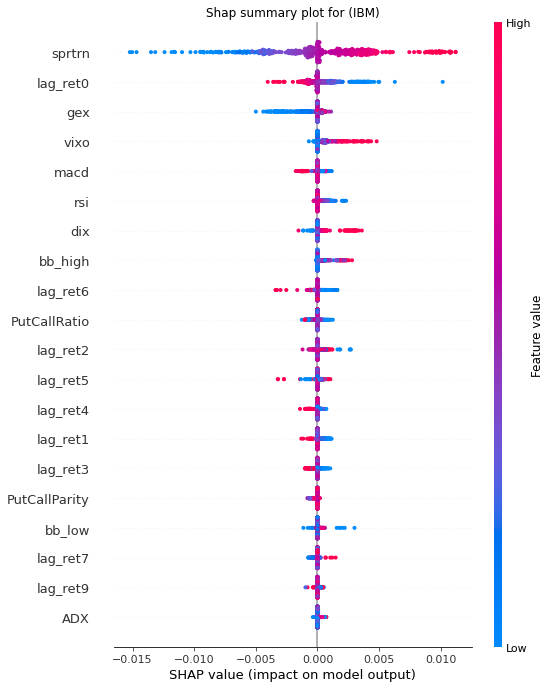

  0%|          | 0/567 [00:00<?, ?it/s]

--------------------------------------
Shap plot for  MSFT
--------------------------------------


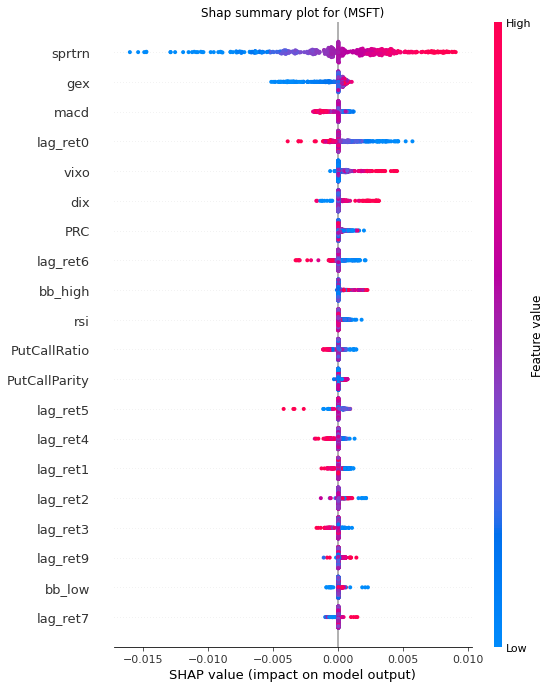

In [ ]:
shap_plot(stack_reg[4][0],'AAPL')
shap_plot(stack_reg[4][1],'IBM')
shap_plot(stack_reg[4][2],'MSFT')

The Shap plot indicates that "sprtrn" variable is the most important feature when making predictions. 

Model predictions is shaped by both individual stock and general market conditions. 

The high (red) and low (blue) values are clearly defined, with no overlapping w.r.t Shap values. This leads to the model making definite predictions since no inconsistency will exist between the features.